In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 21 15:03:32 2023

@author: earyo
"""

#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *


#%%
''' this experiment investigate the influence 
of the ensemble size on the ENKF performance '''

##### for this experiment change the test period to a much shorter one
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'prepare_enkf', 'prepare_enkf2', 'run_enkf', and 'run_enkf2' are defined elsewhere

class Enkf_experiment5:
    
    def __init__(self, num_agents, macro_state_dim, repetitions, ensemble_size, uncertainty_in_models, uncertainty_obs_values, filter_frequency):
        self.num_agents = num_agents
        self.macro_state_dim = macro_state_dim
        self.repetitions = repetitions
        self.ensemble_size = ensemble_size
        self.uncertainty_obs_values = uncertainty_obs_values
        self.uncertainty_in_models = uncertainty_models
        self.filter_frequency = filter_frequency
        self.results_model1 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        self.results_model2 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        
    def run_experiment(self, start_year=1990, end_year=1993):
        
        #### set up result saving arrays
        #array_of_results_enkf1 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        #array_of_results_enkf2 = np.zeros((len(self.uncertainty_in_models), len(self.uncertainty_obs_values)))
        
        
        
        #for idx, uncertainty_models in enumerate(tqdm(self.uncertainty_in_models)):
        for idx, uncertainty_models in enumerate(self.uncertainty_in_models): 
            #print(idx, uncertainty_models)
            #print("this is idx", uncertainty_models)
            

            model_params1 = {"population_size": 100,
                "growth_rate": 0.025,
                "b_begin": 1.3,
                "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                "start_year": start_year,
                "uncertainty_para": uncertainty_models[0]}
            

            model_params2 = {"population_size": 100, 
                "concavity": 1,
                "growth_rate": 0.025, 
                "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                "start_year": start_year,
                "adaptive_sensitivity": 0.02,
                "uncertainty_para": uncertainty_models[1]}
            
            for jdx, uncertainty_obs in enumerate(self.uncertainty_obs_values):
                
                    #print("this is jdx", uncertainty_obs)
                    #print(jdx, uncertainty_obs)
                
                    array_of_results_enkf1_repetitions = np.zeros((self.repetitions, 1))
                    array_of_results_enkf2_repetitions = np.zeros((self.repetitions, 1))
                    #print("this is shape", array_of_results_enkf1_repetitions.shape)
                    for i in range(self.repetitions):
                        
                        enkf1 = prepare_enkf(Model= Model1, model_params = model_params1, 
                                             ensemble_size=self.ensemble_size,
                                             macro_state_dim=self.macro_state_dim,
                                             uncertainty_obs=uncertainty_obs,
                                             filter_freq= self.filter_frequency)
                        
                        enkf2 = prepare_enkf(Model= Model2, model_params = model_params2,
                                             ensemble_size=self.ensemble_size, 
                                             macro_state_dim=self.macro_state_dim,
                                             uncertainty_obs=uncertainty_obs,
                                             filter_freq= self.filter_frequency)
                        
                        run_enkf(enkf1, start_year=start_year, end_year=end_year, filter_freq=10)
                        run_enkf(enkf2, start_year=start_year, end_year=end_year, filter_freq=10)
                        enkf1.make_macro_history_share()
                        enkf2.make_macro_history_share()
                        array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
                        array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
            
                        
                    #print("this is (np.mean(array_of_results_enkf1_repetitions))", np.mean(array_of_results_enkf1_repetitions))
                    #print("this is np.mean(array_of_results_enkf2_repetitions", np.mean(array_of_results_enkf2_repetitions))
                    print("this is idx, jdx", idx, jdx)
                    self.results_model1[idx, jdx] = np.mean(array_of_results_enkf1_repetitions) ## how this is setup idx goes down the rows, which means along the vertical dimension idx = model varies
                    self.results_model2[idx, jdx] = np.mean(array_of_results_enkf2_repetitions)
                            
             
    def plot_heatmap(self, results, model_name, ax=None, save_fig=False, fig_name='fig9.png'):
        # Define the levels of contours
        levels = np.linspace(np.min(results), np.max(results), num=200)
    
        # If an Axes object isn't provided, create a new figure and Axes
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
    
        # Create the contour plot on the provided Axes
        contour = ax.contourf(results, levels=levels, cmap='plasma', extend='neither')
        cbar = plt.colorbar(contour, ax=ax, label='Average Error', extend='neither')
        cbar.ax.set_ylabel('Average distance to Obs.', fontsize=13)
        
        # Set the labels for ticks if needed
        if model_name == 'Model1':
            labels_yaxis = [x[0] for x in self.uncertainty_in_models]
        elif model_name == 'Model2':
            labels_yaxis = [x[1] for x in self.uncertainty_in_models]
    
        ax.set_xticks(ticks=np.arange( len(self.uncertainty_obs_values)), labels=self.uncertainty_obs_values)
        ax.set_yticks(ticks=np.arange(len(self.uncertainty_in_models)), labels=labels_yaxis)
    
        # Set the labels and title
        ax.set_xlabel('Uncertainty data (Std. of wealth groups)', fontsize = 14) # see comment for self.results_model1
        if model_name == 'Model1':
            beta = r'\beta'
            ax.set_ylabel(f'Uncertainty in ${beta}$', fontsize=14)
        elif model_name == 'Model2':
            ax.set_ylabel('Perturbation in win probability', fontsize=14)
        ax.set_title(f'ENKF Performance Heatmap for {model_name}', fontsize = 14)
        
        # Save the figure if requested and if no specific Axes is provided
        if save_fig and ax is None:
            plt.savefig(f"{model_name}_{fig_name}", dpi=300)
    
        # Return the Axes object
        return ax

        
# Usage of the class
start_year = 1990
end_year = 1991


num_agents = 100
macro_state_dim = 4
repetitions = 10  # Example number of repetitions
ensemble_size = 20  # Example ensemble size
filter_frequency = 10
uncertainty_obs = [0.05, 0.1, 0.4, 0.8, 1] ###[0.01, 0.1, 0.5, 1] #[0.1, 0.5, 2, 10]  # Example values for uncertainty_obs
uncertainty_models = [(0.1, 0.1), (0.5, 0.2), (1, 0.5), (2, 0.8), (3, 1)]#[(0.1, 0.1), (0.2, 0.2), (0.5, 0.5), (0.8, 0.8)]
experiment = Enkf_experiment5(num_agents,
                              macro_state_dim,
                              repetitions, 
                              ensemble_size,
                              uncertainty_in_models = uncertainty_models,
                              uncertainty_obs_values = uncertainty_obs,
                              filter_frequency=filter_frequency)
experiment.run_experiment(start_year=start_year, end_year=end_year)

Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 46.74it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 48.95it/s]

this is diff eigenvalues [2.87455836e+13 2.51653168e+11 6.92086984e+08 1.05461926e+07]
this is diff eigenvalues [1.91619874e+11 1.22873602e+10 1.33216575e+08 2.30688536e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.53it/s]

this is diff eigenvalues [3.70217441e+15 7.04747278e+11 8.25573304e+08 2.20711679e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.10it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [6.52009285e+11 1.63078332e+10 3.67095920e+08 6.46393660e+05]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [5.53364482e+13 1.64126153e+11 1.14338680e+09 5.58623125e+06]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 41.56it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.33it/s]


this is diff eigenvalues [1.64781166e+11 3.07455557e+09 1.23991046e+08 3.51661840e+05]


Iterations ENKF <class 'model2_class.Model2'>:  58%|█████▊    | 14/24 [00:01<00:00, 13.38it/s]

this is diff eigenvalues [2.36635453e+14 1.81519253e+11 1.55282278e+09 1.57844243e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 13.26it/s]

this is diff eigenvalues [5.28235580e+11 7.50498611e+09 3.43972461e+08 4.32715852e+05]



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.

this is diff eigenvalues [2.78649208e+14 1.39100394e+11 1.20665506e+09 8.36231806e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 53.05it/s]


this is diff eigenvalues [1.90079197e+11 3.00191250e+09 1.13745809e+08 2.11433655e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:01<00:00, 26.76it/s]

this is diff eigenvalues [2.51970255e+15 5.34693148e+11 1.83093852e+09 1.42083850e+07]
this is diff eigenvalues [9.41424386e+11 1.62852246e+10 2.26187085e+08 7.67561557e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 21.24it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.87it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.31303399e+15 1.03346027e+11 1.28645317e+09 7.00293202e+06]
this is diff eigenvalues [2.23345574e+11 4.94825000e+09 1.33606079e+08 2.01323375e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 27.72it/s]

this is diff eigenvalues [8.32481253e+14 7.91546973e+11 2.19914895e+09 1.12358285e+07]
this is diff eigenvalues [7.87056986e+11 1.52295330e+10 2.26900824e+08 6.81024488e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.32it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.72it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [9.10556197e+13 2.23697546e+11 7.82180118e+08 9.42510542e+06]
this is diff eigenvalues [1.72839608e+11 3.37014323e+09 1.52133235e+08 2.24711137e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 26.95it/s]

this is diff eigenvalues [4.54672236e+14 5.31749868e+11 1.76605657e+09 2.07123900e+07]
this is diff eigenvalues [5.37077301e+11 1.02626153e+10 3.32382408e+08 6.66946129e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.58it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 35.37it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.43245275e+14 1.59398284e+11 8.77263945e+08 7.02181759e+06]
this is diff eigenvalues [2.96126799e+11 3.32628777e+09 1.13834944e+08 2.03564083e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 27.81it/s]

this is diff eigenvalues [3.94521822e+14 6.59905538e+11 1.19731716e+09 2.29038182e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.21it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [9.51645084e+11 2.92975416e+10 1.57139737e+08 6.96561029e+05]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.96it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.67it/s]

this is diff eigenvalues [8.82097978e+13 5.51941478e+10 7.62746261e+08 7.17997538e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.99it/s]


this is diff eigenvalues [1.50454340e+11 4.13262385e+09 1.59925585e+08 1.90786611e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.06it/s]

this is diff eigenvalues [1.24266513e+16 4.12099028e+11 1.26498959e+09 2.36211079e+07]
this is diff eigenvalues [4.63672151e+11 9.06852805e+09 3.03541368e+08 5.67165357e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 22.91it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.94it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.05162976e+13 1.23372936e+11 1.70449218e+09 1.34674688e+07]
this is diff eigenvalues [1.47383447e+11 3.53500185e+09 1.50247846e+08 2.75739711e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.16it/s]

this is diff eigenvalues [2.83880840e+13 1.32942372e+11 9.77759471e+08 2.79426914e+07]
this is diff eigenvalues [5.06238205e+11 1.07193987e+10 4.17931998e+08 3.63677340e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.32it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.53858835e+13 1.85648698e+11 1.91090376e+09 1.08970098e+07]
this is diff eigenvalues [2.22861097e+11 2.48262997e+09 1.75466510e+08 2.90312686e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 27.88it/s]

this is diff eigenvalues [2.53005024e+15 2.46978717e+11 1.51145247e+09 2.01530557e+07]
this is diff eigenvalues [4.86424563e+11 9.80209660e+09 2.88115229e+08 5.69339621e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.08it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 32.74it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.45868719e+13 6.83053440e+10 1.12937411e+09 5.62296614e+06]
this is diff eigenvalues [1.64861726e+11 4.91018814e+09 1.38098156e+08 1.93729375e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.83it/s]

this is diff eigenvalues [1.58224581e+14 2.87322651e+11 2.37851674e+09 2.61339387e+07]
this is diff eigenvalues [4.09977739e+11 7.86883330e+09 2.46739846e+08 4.67280396e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.96it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 0 0


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 52.80it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  54%|█████▍    | 13/24 [00:00<00:00, 56.21it/s]

this is diff eigenvalues [1.27197726e+15 6.49725421e+10 1.85098529e+09 1.42774645e+07]


Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 40.50it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.96it/s]


this is diff eigenvalues [6.95483999e+11 1.14495320e+10 6.20683063e+08 1.04399099e+06]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.94it/s]

this is diff eigenvalues [1.41087605e+15 2.79798016e+11 1.49762730e+09 1.85676218e+07]
this is diff eigenvalues [7.29723853e+11 1.50671251e+10 7.14163556e+08 1.26473907e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.43it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.22it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.10530781e+14 1.98882960e+11 1.14161744e+09 6.79592263e+06]
this is diff eigenvalues [7.24556739e+11 1.27462131e+10 5.01377892e+08 8.30985895e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.17it/s]

this is diff eigenvalues [2.33446975e+13 2.52138741e+11 1.36408585e+09 1.50267812e+07]
this is diff eigenvalues [1.05029839e+12 3.33753303e+10 9.81206506e+08 1.38340881e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.92it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.20it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.03177705e+15 1.84385492e+11 1.23430594e+07 1.03304049e+09]
this is diff eigenvalues [8.11207798e+11 1.54479266e+10 5.41229467e+08 9.24900956e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.51it/s]

this is diff eigenvalues [7.82519252e+13 1.24107074e+11 2.31329421e+09 1.13352948e+07]
this is diff eigenvalues [7.65682872e+11 2.21214216e+10 8.84812771e+08 1.13776678e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.39it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 32.28it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.85283074e+13 4.25340821e+11 1.72636168e+09 1.13568193e+07]
this is diff eigenvalues [6.74933891e+11 1.39302139e+10 3.95959068e+08 7.44455385e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.81it/s]

this is diff eigenvalues [4.47105090e+14 4.04231343e+11 1.69140588e+09 1.31888007e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.83it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.16521710e+12 2.79182285e+10 7.35810182e+08 1.06479607e+06]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 51.51it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [3.47420838e+13 8.18893163e+10 1.11360924e+09 1.71002928e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 38.41it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 43.70it/s]


this is diff eigenvalues [7.50545294e+11 1.16697094e+10 4.94001139e+08 7.61279906e+05]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.12it/s]

this is diff eigenvalues [3.37426873e+14 3.14256915e+11 1.82578567e+09 2.91435067e+07]
this is diff eigenvalues [9.86472652e+11 3.17137115e+10 5.36694228e+08 1.26271519e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.95it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.42it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [9.03574586e+13 2.95956909e+11 1.58208850e+09 7.64564844e+06]
this is diff eigenvalues [5.56485584e+11 1.56913050e+10 5.31198257e+08 9.28769198e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.11it/s]

this is diff eigenvalues [1.70082160e+13 1.48756531e+11 1.05340966e+09 1.67282849e+07]
this is diff eigenvalues [1.07528137e+12 2.01676917e+10 6.46627880e+08 7.76517822e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 21.28it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.81it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.57898175e+15 8.28242122e+10 1.51175784e+09 1.03330393e+07]
this is diff eigenvalues [9.66437979e+11 1.68101335e+10 4.31427319e+08 9.60679218e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.60it/s]

this is diff eigenvalues [2.67023015e+15 4.78650908e+11 1.70197545e+09 2.43652754e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.64it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [7.69807827e+11 1.80947904e+10 7.93246183e+08 1.36187341e+06]


Iterations ENKF <class 'model1_class.Model1'>:  33%|███▎      | 8/24 [00:00<00:00, 33.43it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 47.22it/s]

this is diff eigenvalues [2.19323407e+14 3.91548588e+11 9.26183950e+08 9.23721118e+06]
this is diff eigenvalues [7.46952276e+11 2.55836525e+10 4.12406436e+08 8.85462891e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.24it/s]

this is diff eigenvalues [5.33177341e+13 1.35263165e+11 3.67716850e+09 1.76133826e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.57it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.40297406e+12 1.87065822e+10 6.38058931e+08 2.24797469e+06]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 36.32it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 42.56it/s]

this is diff eigenvalues [2.04516268e+14 1.20926683e+11 2.18376716e+09 1.21555394e+07]
this is diff eigenvalues [6.72311783e+11 1.61683182e+10 5.66520438e+08 8.42058895e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 27.81it/s]

this is diff eigenvalues [1.35241517e+14 3.37870487e+11 1.09553716e+09 1.86456145e+07]
this is diff eigenvalues [1.17245657e+12 2.14595282e+10 6.82318992e+08 1.47289314e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.26it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 65.97it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [3.05152516e+13 1.97411788e+11 1.67711958e+07 8.38167958e+08]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 39.24it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.16it/s]


this is diff eigenvalues [7.04544082e+11 1.06104250e+10 3.88532604e+08 9.53014676e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.35it/s]

this is diff eigenvalues [1.65586086e+16 2.66982827e+11 3.89486826e+09 2.14217637e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.26it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.18165650e+12 2.82283883e+10 7.12363821e+08 1.49309605e+06]
this is idx, jdx 0 1


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.55it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.22it/s]

this is diff eigenvalues [1.34079285e+15 3.86973006e+11 5.60902805e+09 2.21119303e+07]
this is diff eigenvalues [1.02247573e+13 1.93683501e+11 5.23195894e+09 1.05362370e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 26.29it/s]

this is diff eigenvalues [1.24255713e+15 3.36381438e+11 5.57264366e+09 2.30380059e+07]
this is diff eigenvalues [1.56676390e+13 2.35931042e+11 6.71533956e+09 1.28940807e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.02it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.76it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.12868965e+13 1.62509497e+11 5.49473139e+09 1.54414204e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 15.80it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.67it/s]

this is diff eigenvalues [8.84180774e+12 1.45457800e+11 4.93790310e+09 1.06467691e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.20it/s]

this is diff eigenvalues [1.86254260e+13 2.89492530e+11 6.10047729e+09 5.39420853e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 10.52it/s]

this is diff eigenvalues [1.12928882e+13 2.87063166e+11 5.86248977e+09 1.69442463e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.59it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 14.99it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.92524050e+13 1.99234343e+11 6.44717042e+09 2.19885421e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.80it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.93it/s]

this is diff eigenvalues [8.14846449e+12 1.42070042e+11 5.45821437e+09 1.34947121e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.15it/s]

this is diff eigenvalues [6.59092718e+13 2.02179656e+11 5.62718889e+09 3.56245932e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 10.39it/s]

this is diff eigenvalues [1.13353872e+13 1.86532190e+11 5.78822293e+09 1.52225375e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.63it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 16.51it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.45049586e+14 1.21289970e+12 5.77060242e+09 3.52348161e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 13.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  96%|█████████▌| 23/24 [00:01<00:00, 13.92it/s]

this is diff eigenvalues [9.67653333e+12 1.71774674e+11 5.26678163e+09 1.23235302e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.42it/s]

this is diff eigenvalues [6.82101234e+13 3.04209316e+11 5.33541353e+09 2.17914174e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.95it/s]

this is diff eigenvalues [1.05285422e+13 2.29997765e+11 5.50063364e+09 1.07832572e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.40it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.22314856e+13 1.52789764e+11 5.11922983e+09 2.38655566e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 14.31it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.78it/s]


this is diff eigenvalues [9.15195018e+12 1.40358313e+11 5.17917490e+09 1.35469874e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.29it/s]

this is diff eigenvalues [9.51930214e+13 3.27120015e+11 6.50208429e+09 2.71657827e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.18it/s]

this is diff eigenvalues [1.24969156e+13 1.93879771e+11 5.91506385e+09 1.73337097e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.58it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.93it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.78311161e+16 2.97025363e+11 5.13368183e+09 1.35942843e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.05it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.25it/s]

this is diff eigenvalues [1.05217546e+13 1.51289989e+11 5.18101969e+09 1.05704856e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.46it/s]

this is diff eigenvalues [4.81132036e+14 3.74879241e+11 6.27653183e+09 1.71667162e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 10.91it/s]

this is diff eigenvalues [1.45119707e+13 2.19434628e+11 6.22741597e+09 1.14079123e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.74it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.81it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.12870806e+14 2.51141915e+11 6.09340465e+09 3.08656104e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.17it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 15.60it/s]

this is diff eigenvalues [9.60226598e+12 1.54882538e+11 5.11567037e+09 1.20008692e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.15it/s]

this is diff eigenvalues [9.60530872e+13 2.23787918e+11 5.86844102e+09 3.50180780e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.59it/s]

this is diff eigenvalues [1.10456804e+13 2.00280072e+11 5.74713204e+09 1.71401205e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.67it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 13.11it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.98245639e+13 3.01230789e+11 5.27833285e+09 2.96029661e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 14.35it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.04it/s]


this is diff eigenvalues [7.36994480e+12 1.60670230e+11 4.88349855e+09 1.08631310e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.35it/s]

this is diff eigenvalues [5.11899544e+13 4.76723023e+11 6.30748125e+09 4.55660363e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]

this is diff eigenvalues [1.18586964e+13 1.85237192e+11 5.33117707e+09 1.27940157e+07]



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.38it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self

this is diff eigenvalues [2.18732755e+17 3.47085959e+11 5.60996701e+09 1.77625963e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 11.19it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.43it/s]


this is diff eigenvalues [2.07804061e+13 3.64926885e+11 5.09971096e+09 1.09493746e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.29it/s]

this is diff eigenvalues [9.96356130e+13 4.12927487e+11 6.27546009e+09 1.82474486e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.52it/s]

this is diff eigenvalues [1.17974682e+13 2.00787078e+11 6.91439587e+09 1.55760394e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.75it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 17.58it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.56421409e+13 2.20976867e+11 6.50349414e+09 2.12474721e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 17.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.73it/s]


this is diff eigenvalues [8.23146144e+12 1.94408602e+11 5.47930284e+09 9.87199688e+06]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.22it/s]

this is diff eigenvalues [1.18495956e+14 4.00047064e+11 6.28016545e+09 3.29965443e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.84it/s]

this is diff eigenvalues [1.49558908e+13 2.62191146e+11 5.45242271e+09 1.30827331e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.78it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 0 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.67it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 16.36it/s]

this is diff eigenvalues [3.85647597e+13 4.84726548e+11 1.90411053e+10 4.83230938e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.35it/s]


this is diff eigenvalues [2.92516857e+13 4.68754794e+11 1.89468632e+10 3.88216304e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.24it/s]

this is diff eigenvalues [1.85079039e+14 5.39044139e+11 2.02266232e+10 4.00354879e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.39it/s]

this is diff eigenvalues [5.58396618e+13 5.49346598e+11 2.03523986e+10 3.85363946e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.74it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 12.94it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [9.70322348e+13 4.94062325e+11 1.88170438e+10 4.01345989e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.70it/s]

this is diff eigenvalues [3.29840636e+13 5.24414228e+11 1.90595325e+10 4.01265612e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:01,  5.53it/s]

this is diff eigenvalues [7.67237944e+14 5.33273065e+11 1.91663383e+10 4.03352525e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 11.70it/s]

this is diff eigenvalues [3.74371406e+13 5.22023458e+11 1.97634533e+10 4.24412798e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.93it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.54611752e+14 4.81785431e+11 4.68755590e+07 1.86820567e+10]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 13.10it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.70it/s]

this is diff eigenvalues [3.70775144e+13 4.79219286e+11 1.91258136e+10 4.16089873e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.31it/s]

this is diff eigenvalues [1.50807113e+14 6.11064230e+11 1.93786548e+10 3.60028089e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.18it/s]

this is diff eigenvalues [3.80382182e+13 7.49719765e+11 2.00561950e+10 4.12373282e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.71it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.18it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.49475189e+14 8.80697362e+11 1.84124542e+10 4.27199649e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.42it/s]


this is diff eigenvalues [3.35892115e+13 6.37121978e+11 3.88077567e+07 1.86376424e+10]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.44it/s]

this is diff eigenvalues [1.31794319e+14 6.80009164e+11 2.03766718e+10 5.45445578e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 11.16it/s]

this is diff eigenvalues [4.95515796e+13 5.81683105e+11 2.01049456e+10 5.01619843e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.79it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.56it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.38578171e+14 4.86236091e+11 1.83903934e+10 3.77059259e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.91it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.96it/s]


this is diff eigenvalues [4.57963472e+13 4.93948255e+11 1.88665165e+10 3.65035198e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.27it/s]

this is diff eigenvalues [6.99705349e+13 7.76848111e+11 1.90445236e+10 6.04635286e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.59it/s]

this is diff eigenvalues [3.88079025e+13 6.63406202e+11 2.06250902e+10 5.75603266e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.75it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 14.87it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.68784542e+14 4.86017443e+11 3.92214410e+07 1.96149860e+10]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.09it/s]

this is diff eigenvalues [3.95213740e+13 4.99747021e+11 1.93388824e+10 3.71384044e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.49it/s]

this is diff eigenvalues [1.15961296e+16 5.43236798e+11 1.95558395e+10 4.46411058e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.79it/s]

this is diff eigenvalues [2.94469544e+13 5.55096275e+11 1.94471764e+10 4.65845250e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.81it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 17.90it/s]

this is diff eigenvalues [2.44161781e+13 5.80434231e+11 1.87026703e+10 4.19113531e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 14.75it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.70it/s]

this is diff eigenvalues [2.26876926e+13 5.38983392e+11 1.93124214e+10 3.96261138e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.32it/s]

this is diff eigenvalues [1.22568800e+14 6.83358149e+11 4.65049648e+07 1.91535066e+10]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.78it/s]

this is diff eigenvalues [4.27094152e+13 6.42705153e+11 4.56751878e+07 2.01910126e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 19.10it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.35232446e+14 5.55135810e+11 1.89031148e+10 4.37948094e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 17.37it/s]

this is diff eigenvalues [3.17825278e+13 5.21068440e+11 1.90967878e+10 3.80565954e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.44it/s]

this is diff eigenvalues [1.22912392e+14 6.54190625e+11 1.87891554e+10 5.30159109e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.35it/s]

this is diff eigenvalues [4.00640457e+13 5.93836427e+11 1.97511205e+10 4.51095295e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.83it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 19.09it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.70956217e+13 5.95054016e+11 1.92949085e+10 4.20250780e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 15.72it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  96%|█████████▌| 23/24 [00:01<00:00, 15.78it/s]

this is diff eigenvalues [3.10962523e+13 5.09988961e+11 1.98354955e+10 4.10535075e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.30it/s]

this is diff eigenvalues [9.78081323e+13 6.28476732e+11 2.04372555e+10 4.72033291e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.34it/s]

this is diff eigenvalues [3.43354827e+13 5.50998777e+11 2.11730235e+10 4.11989344e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.74it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 18.90it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.47800416e+14 6.89131856e+11 1.92883005e+10 5.11380548e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.51it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.56it/s]


this is diff eigenvalues [3.58257882e+13 5.23230205e+11 1.93809339e+10 4.45861889e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.45it/s]

this is diff eigenvalues [1.21592049e+14 5.89302737e+11 2.00087143e+10 4.87391335e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00, 12.23it/s]

this is diff eigenvalues [3.38369973e+13 6.06438097e+11 2.06146046e+10 4.05534549e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 0 3


Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 14.76it/s]

this is diff eigenvalues [2.18980437e+14 7.10809875e+11 2.88056066e+10 5.62191723e+07]


Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 16.07it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.00it/s]


this is diff eigenvalues [4.91493752e+13 7.54593447e+11 2.94756966e+10 5.87447603e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.40it/s]

this is diff eigenvalues [3.11335130e+14 1.16851190e+12 2.93627596e+10 5.10118182e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.50it/s]

this is diff eigenvalues [6.10430565e+13 7.46909978e+11 3.04825617e+10 5.84131109e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.76it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 19.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.75718618e+13 9.27172214e+11 2.88381845e+10 5.71340552e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.63it/s]

this is diff eigenvalues [4.02877476e+13 8.58130283e+11 2.94473651e+10 6.06202571e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.41it/s]

this is diff eigenvalues [5.51034714e+13 7.98566128e+11 3.04570566e+10 7.65228390e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.78it/s]

this is diff eigenvalues [4.96130385e+13 8.27313164e+11 7.03428421e+07 3.11940652e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.83it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.33070655e+13 7.62967783e+11 2.86199188e+10 5.65096490e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.28it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 16.03it/s]

this is diff eigenvalues [4.38853007e+13 7.60873905e+11 2.91991598e+10 5.84164587e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.35it/s]

this is diff eigenvalues [2.30254888e+14 1.16959159e+12 3.05310155e+10 7.48431070e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 10.98it/s]

this is diff eigenvalues [6.90167447e+13 1.14236457e+12 3.09627523e+10 6.93743856e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.74it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.72it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.47831965e+14 7.77774213e+11 2.84662222e+10 6.53538384e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.78it/s]


this is diff eigenvalues [4.81242688e+13 7.68417480e+11 2.90465339e+10 5.88602900e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.43it/s]

this is diff eigenvalues [1.17306460e+14 1.05877688e+12 3.02448505e+10 7.32231836e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.81it/s]

this is diff eigenvalues [4.77640860e+13 1.11986550e+12 3.01808654e+10 6.38054785e+07]



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 15.41it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self

this is diff eigenvalues [6.82055745e+13 7.87746285e+11 2.88772916e+10 5.06540339e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.57it/s]


this is diff eigenvalues [4.55715333e+13 7.83180931e+11 2.95529347e+10 5.35954937e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.31it/s]

this is diff eigenvalues [5.32770763e+13 9.87383314e+11 8.28523327e+07 2.94130959e+10]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.85it/s]

this is diff eigenvalues [4.54018520e+13 9.13623780e+11 3.02673810e+10 8.14254688e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.76it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  54%|█████▍    | 13/24 [00:00<00:00, 13.57it/s]

this is diff eigenvalues [2.87250482e+14 8.56307307e+11 2.81224612e+10 4.68580228e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 15.12it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.50it/s]

this is diff eigenvalues [5.17427774e+13 8.44801878e+11 2.89597149e+10 5.28933319e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.41it/s]

this is diff eigenvalues [1.26107592e+14 7.98540730e+11 2.86015885e+10 6.27325468e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 12.12it/s]

this is diff eigenvalues [6.36300801e+13 8.32375121e+11 2.99635153e+10 6.51854798e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.87it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.24012276e+14 7.07298547e+11 2.82626563e+10 4.95865591e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 11.74it/s]

this is diff eigenvalues [5.15379417e+13 7.34542135e+11 2.88929401e+10 5.25096033e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.49it/s]

this is diff eigenvalues [1.28188303e+15 7.88230981e+11 3.06848508e+10 6.42100322e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 10.35it/s]

this is diff eigenvalues [6.11929601e+13 9.48252648e+11 3.25134497e+10 7.75970952e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.60it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  62%|██████▎   | 15/24 [00:00<00:00, 18.31it/s]

this is diff eigenvalues [5.24149012e+13 6.75258458e+11 2.82627246e+10 4.86958992e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 16.70it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  96%|█████████▌| 23/24 [00:01<00:00, 16.18it/s]

this is diff eigenvalues [4.68691558e+13 7.03130591e+11 2.90157186e+10 5.36067927e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.13it/s]

this is diff eigenvalues [1.19895542e+14 9.74571269e+11 2.98183578e+10 5.59524447e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 10.88it/s]

this is diff eigenvalues [5.73280146e+13 9.97649531e+11 3.16234456e+10 6.56262422e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.66it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.89it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.49830141e+14 7.51889111e+11 2.84124250e+10 5.37781773e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 18.20it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.78it/s]


this is diff eigenvalues [4.79832141e+13 8.09450694e+11 2.89677779e+10 5.42861613e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:01,  5.55it/s]

this is diff eigenvalues [4.98299185e+14 8.86889173e+11 2.92963479e+10 6.56830355e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 11.25it/s]

this is diff eigenvalues [5.63961864e+13 8.47942245e+11 3.07792891e+10 7.86351494e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.88it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 14.89it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.43160356e+14 7.98633880e+11 2.90796142e+10 6.76199748e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.78it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.61it/s]


this is diff eigenvalues [4.11402001e+13 7.39395332e+11 2.96284276e+10 6.09499460e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.24it/s]

this is diff eigenvalues [5.12594547e+13 7.16698704e+11 2.92217994e+10 6.48638110e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.18it/s]

this is diff eigenvalues [5.60097324e+13 7.75546256e+11 3.03633469e+10 7.25877790e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.68it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 0 4


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.99it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 16.67it/s]

this is diff eigenvalues [1.48364328e+13 2.00887878e+11 1.61456916e+07 9.03796783e+08]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 13.53it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.13it/s]


this is diff eigenvalues [1.87573232e+11 4.73314409e+09 1.27337380e+08 2.27634398e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.34it/s]

this is diff eigenvalues [1.52352374e+15 4.44239503e+11 1.83115777e+09 2.16268909e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.90it/s]

this is diff eigenvalues [5.52387374e+11 5.89598188e+09 2.31046412e+08 9.57466153e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.78it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.83it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.57412459e+14 7.29561200e+10 5.40525538e+08 4.98008562e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.81it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.99it/s]


this is diff eigenvalues [2.05568113e+11 2.83817675e+09 1.23654635e+08 2.68368856e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  4.72it/s]

this is diff eigenvalues [5.52707152e+14 1.10175165e+11 1.95884626e+09 9.18554419e+06]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.25it/s]

this is diff eigenvalues [3.98655037e+11 8.38306457e+09 2.33103180e+08 4.11143809e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.55it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.81it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.09616993e+15 7.68962895e+10 8.64052235e+06 5.58390220e+08]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.04it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 17.26it/s]

this is diff eigenvalues [1.91686135e+11 2.98422262e+09 1.53900932e+08 2.30766591e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.39it/s]

this is diff eigenvalues [4.55062054e+13 4.41563628e+10 3.63067062e+09 4.64381333e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 11.14it/s]

this is diff eigenvalues [4.95498545e+11 5.15801073e+09 2.09906118e+08 4.68562776e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.71it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.05it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.34597756e+13 2.75396792e+10 1.02451893e+09 1.10549312e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.39it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 16.41it/s]

this is diff eigenvalues [1.55525616e+11 4.04138774e+09 1.19019253e+08 2.11182668e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.28it/s]

this is diff eigenvalues [3.34630978e+13 2.15367962e+11 1.60770496e+09 2.06705060e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.82it/s]

this is diff eigenvalues [5.96273837e+11 5.68429257e+09 2.06520087e+08 9.16476494e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.82it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 13.25it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.99817498e+14 1.14452050e+11 1.27147934e+09 1.10456350e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 14.49it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 15.09it/s]

this is diff eigenvalues [1.57483560e+11 8.05772457e+09 1.62441509e+08 2.79595537e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.46it/s]

this is diff eigenvalues [1.77867688e+13 2.39586903e+11 1.08515663e+09 1.84925364e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00, 12.23it/s]

this is diff eigenvalues [5.74882480e+11 1.27786352e+10 1.92992747e+08 1.28980140e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.83it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.64it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.91282189e+13 5.78888846e+10 9.52699832e+08 7.06298222e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 11.20it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


this is diff eigenvalues [2.29377282e+11 3.29566748e+09 1.39681020e+08 2.46207130e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.23it/s]

this is diff eigenvalues [6.15356481e+16 8.85905288e+11 1.28441038e+09 1.19800723e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.27it/s]

this is diff eigenvalues [6.93636385e+11 5.06421446e+09 2.11890879e+08 8.17148114e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.73it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.34it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.79031880e+13 1.20729103e+11 1.06822175e+09 9.65230507e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.94it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 16.53it/s]

this is diff eigenvalues [1.58385712e+11 3.47869170e+09 1.24961404e+08 1.91370491e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.30it/s]

this is diff eigenvalues [1.00312291e+13 1.09989990e+11 2.41163188e+09 3.04983159e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.60it/s]

this is diff eigenvalues [5.02402480e+11 8.42235805e+09 2.34620190e+08 6.32012075e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.66it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 15.86it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.59387610e+14 1.08882820e+11 1.12978529e+09 1.22286440e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.68it/s]


this is diff eigenvalues [1.69908369e+11 4.06021805e+09 2.18321199e+08 1.97665377e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.42it/s]

this is diff eigenvalues [9.53346859e+14 5.36743507e+11 2.82722713e+09 1.19257191e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.25it/s]

this is diff eigenvalues [5.61259775e+11 2.51930781e+10 1.82456425e+08 3.13593258e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.73it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 14.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.69474192e+13 1.05656230e+11 8.47557010e+08 1.60519998e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.08it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.83it/s]

this is diff eigenvalues [1.34812181e+11 5.02948114e+09 1.96011577e+08 2.04154176e+05]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.48it/s]

this is diff eigenvalues [6.53115632e+13 8.77691924e+10 1.07308586e+09 1.85327484e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 11.09it/s]

this is diff eigenvalues [3.95395985e+11 7.11324906e+09 2.93478057e+08 6.26023798e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.70it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.33098985e+13 7.48817506e+10 4.92782875e+06 1.51883232e+09]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 13.11it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


this is diff eigenvalues [1.45449911e+11 3.63127307e+09 1.42497013e+08 2.84512022e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.31it/s]

this is diff eigenvalues [2.82017795e+13 1.68758593e+11 1.75194195e+09 1.09808971e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.01it/s]

this is diff eigenvalues [4.67647852e+11 1.16127457e+10 2.11767564e+08 4.60560602e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.66it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 1 0


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.58it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 17.19it/s]

this is diff eigenvalues [2.14593975e+15 2.45602903e+11 1.09323972e+09 7.34427833e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.63it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 16.50it/s]

this is diff eigenvalues [5.83836591e+11 1.20393288e+10 5.41285039e+08 9.20734755e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.36it/s]

this is diff eigenvalues [2.07454486e+14 2.70197430e+11 2.64783303e+09 1.02063516e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.93it/s]

this is diff eigenvalues [1.23701516e+12 3.79497408e+10 8.46873544e+08 1.12918398e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.80it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 18.13it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.93589727e+14 8.21064247e+10 9.23147859e+08 1.59880643e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.43it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.95it/s]


this is diff eigenvalues [7.29478192e+11 1.07481518e+10 4.16239638e+08 8.44501224e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.31it/s]

this is diff eigenvalues [5.47937297e+14 3.53469188e+11 2.83073988e+09 2.11504965e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 12.37it/s]

this is diff eigenvalues [9.04364598e+11 1.99145096e+10 5.82810672e+08 1.13145981e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.80it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.06it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.10209371e+13 1.06936255e+11 1.21417945e+09 8.46336154e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.56it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 16.70it/s]

this is diff eigenvalues [5.99699073e+11 1.12388509e+10 5.48558012e+08 7.06942843e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.40it/s]

this is diff eigenvalues [1.02265448e+14 5.02303156e+11 2.28966779e+09 1.26628795e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.58it/s]

this is diff eigenvalues [9.03259712e+11 3.35215858e+10 5.44694265e+08 1.14238175e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.79it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 12.56it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [9.31776257e+12 1.01154890e+11 1.16372464e+09 6.30553529e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 15.44it/s]

this is diff eigenvalues [5.67538914e+11 9.08918049e+09 4.40721537e+08 7.74998498e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.30it/s]

this is diff eigenvalues [6.49161831e+14 2.85015825e+11 1.94532250e+09 1.32228228e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.29it/s]

this is diff eigenvalues [1.10624118e+12 3.33286233e+10 5.57508891e+08 1.06747092e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.69it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.02it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.61256456e+14 3.01837698e+11 1.21552677e+09 8.90292688e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 11.20it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


this is diff eigenvalues [9.15075309e+11 1.20281945e+10 4.41318619e+08 7.14102929e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.34it/s]

this is diff eigenvalues [4.96167877e+13 9.73862669e+10 1.84826069e+09 1.19144219e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 10.87it/s]

this is diff eigenvalues [1.08753795e+12 2.65363113e+10 9.28503691e+08 1.79527561e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.77it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.44it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.19603517e+13 1.60275633e+11 1.63628528e+09 6.27796161e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.67it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.01it/s]


this is diff eigenvalues [6.95350882e+11 1.05803942e+10 4.61010930e+08 8.64864044e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.38it/s]

this is diff eigenvalues [4.96078431e+14 3.73688369e+11 1.21947485e+09 1.55491767e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.86it/s]

this is diff eigenvalues [8.79295246e+11 2.82782917e+10 6.19468638e+08 9.97386547e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.78it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.61it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.72721573e+13 1.37401613e+11 1.52070054e+09 1.47957729e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.45it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.44it/s]


this is diff eigenvalues [4.91757991e+11 1.34984314e+10 4.40327544e+08 7.07915299e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.43it/s]

this is diff eigenvalues [7.79039022e+13 1.17268726e+11 2.25556401e+09 2.70549641e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.30it/s]

this is diff eigenvalues [1.13262018e+12 2.52119661e+10 5.91465756e+08 1.78872631e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.83it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 13.15it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.96691566e+13 3.29198478e+11 1.83339546e+09 9.21707990e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.40it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.18it/s]


this is diff eigenvalues [8.22101336e+11 2.40777421e+10 4.81796945e+08 7.51801123e+05]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.50it/s]

this is diff eigenvalues [8.18671845e+14 2.01256158e+11 9.63386056e+08 2.05646372e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.88it/s]

this is diff eigenvalues [1.69359530e+12 4.63738125e+10 5.29183303e+08 1.87226446e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.77it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 15.76it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.13864357e+12 8.40107064e+10 1.53501414e+09 4.96581122e+06]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 13.34it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.71it/s]

this is diff eigenvalues [5.99805449e+11 1.20683713e+10 5.91330586e+08 8.33536749e+05]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.37it/s]

this is diff eigenvalues [1.65251507e+15 2.89556460e+11 1.60834222e+09 2.03602556e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.43it/s]

this is diff eigenvalues [1.46794125e+12 1.89057505e+10 8.04825138e+08 1.21963219e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.73it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 18.75it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.98448046e+14 1.71677981e+11 1.22225225e+09 8.00278018e+06]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 17.94it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 18.53it/s]


this is diff eigenvalues [8.86813189e+11 1.58144753e+10 4.46503319e+08 1.20252806e+06]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.48it/s]

this is diff eigenvalues [4.16513890e+14 1.42386233e+11 8.43004448e+08 1.15892197e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.19it/s]

this is diff eigenvalues [1.03054420e+12 3.03150129e+10 5.69581098e+08 1.65380058e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  6.00it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 1 1


Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 18.08it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  54%|█████▍    | 13/24 [00:00<00:00, 17.01it/s]

this is diff eigenvalues [7.67247606e+14 3.72413642e+11 5.77291323e+09 1.67004754e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 17.29it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.36it/s]


this is diff eigenvalues [9.36936388e+12 1.42196525e+11 5.46256797e+09 1.33595784e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.35it/s]

this is diff eigenvalues [2.28207379e+14 4.99532156e+11 6.35137177e+09 3.89040189e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.78it/s]

this is diff eigenvalues [1.27523757e+13 1.77784156e+11 6.19767234e+09 1.64390734e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 14.42it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.57228506e+15 1.48027300e+11 5.52578980e+09 3.07989922e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 15.96it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.17it/s]

this is diff eigenvalues [8.09474303e+12 1.33727868e+11 5.46243590e+09 1.23617034e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.48it/s]

this is diff eigenvalues [1.07219546e+14 3.81583455e+11 6.15900492e+09 3.40928119e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.53it/s]

this is diff eigenvalues [1.43722637e+13 1.90533798e+11 6.16299027e+09 1.62894585e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.90it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  42%|████▏     | 10/24 [00:00<00:00, 18.24it/s]

this is diff eigenvalues [5.68868510e+13 3.48881620e+11 6.45941425e+09 2.70365078e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:01, 11.72it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.41it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.05it/s]


this is diff eigenvalues [9.21145733e+12 1.71497056e+11 5.11029124e+09 1.10156602e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.37it/s]

this is diff eigenvalues [8.87116776e+13 4.90492635e+11 5.97003169e+09 1.95250243e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 12.03it/s]

this is diff eigenvalues [1.33242685e+13 2.11707067e+11 5.91964979e+09 1.17734492e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.89it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.99it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.84484038e+13 2.38176349e+11 5.27630859e+09 2.20744344e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 16.86it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [1.10981385e+13 1.56676278e+11 5.04116296e+09 1.39588248e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.39it/s]

this is diff eigenvalues [2.30304808e+13 5.33235775e+11 6.98032794e+09 3.29423225e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.76it/s]

this is diff eigenvalues [1.13512232e+13 1.47934919e+11 1.08197420e+07 5.60184343e+09]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.86it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 17.07it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.94019410e+13 5.78487241e+11 5.68791263e+09 2.02978750e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 16.04it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.63it/s]

this is diff eigenvalues [9.14444598e+12 1.66739290e+11 5.68099126e+09 1.10315172e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.38it/s]

this is diff eigenvalues [3.33606881e+14 3.02131553e+11 5.47785929e+09 2.58687033e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.90it/s]

this is diff eigenvalues [1.14526768e+13 1.96245764e+11 5.09548356e+09 1.39784913e+07]



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  42%|████▏     | 10/24 [00:00<00:00, 17.11it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self

this is diff eigenvalues [2.27027532e+14 2.49935158e+11 5.43525681e+09 1.64825933e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 17.25it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.36it/s]


this is diff eigenvalues [1.22974228e+13 1.49986407e+11 5.40460238e+09 1.35019552e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:01,  5.58it/s]

this is diff eigenvalues [4.80859241e+15 1.31547078e+12 6.16140598e+09 2.43499399e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.20it/s]

this is diff eigenvalues [1.16343505e+13 1.68065954e+11 6.00680021e+09 1.62902650e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.99it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 13.07it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.50943600e+14 2.44174130e+11 5.41600125e+09 1.88933950e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 14.90it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.44it/s]


this is diff eigenvalues [1.21126259e+13 1.38947484e+11 5.29259618e+09 1.19821044e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.46it/s]

this is diff eigenvalues [2.39445707e+15 2.03603861e+11 5.33640672e+09 2.60604150e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:03<00:00, 11.45it/s]

this is diff eigenvalues [1.07941318e+13 1.43003228e+11 5.86103498e+09 1.39867609e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.86it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.81it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.49170254e+13 1.39256001e+11 5.90351926e+09 2.68427243e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 13.50it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.22it/s]


this is diff eigenvalues [1.01630851e+13 1.29588880e+11 5.30830663e+09 1.18013537e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.35it/s]

this is diff eigenvalues [3.38391343e+14 4.37475525e+11 5.91321073e+09 2.65446771e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.51it/s]

this is diff eigenvalues [1.51875518e+13 2.24172747e+11 5.57937278e+09 1.66422982e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.81it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.65it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.06173170e+16 2.61135835e+11 5.01970338e+09 1.49059191e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.21it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.96it/s]

this is diff eigenvalues [8.87033084e+12 2.13086152e+11 5.03816929e+09 1.01140836e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:01,  5.51it/s]

this is diff eigenvalues [6.48211276e+13 2.68919165e+11 3.19631105e+07 5.78800927e+09]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.03it/s]

this is diff eigenvalues [1.54857169e+13 1.76966783e+11 5.27733780e+09 1.22012036e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.93it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.39036075e+15 4.80962140e+11 5.75753437e+09 1.88787500e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.63it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.99it/s]


this is diff eigenvalues [7.94960094e+12 2.25384089e+11 5.78041351e+09 1.27464969e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.42it/s]

this is diff eigenvalues [5.71360322e+13 2.25433076e+11 6.26576257e+09 2.63089453e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.04it/s]

this is diff eigenvalues [8.16639587e+12 1.56839246e+11 5.79708934e+09 1.38955962e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.92it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 1 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 15.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:01<00:00, 16.03it/s]

this is diff eigenvalues [4.83593802e+13 5.24380624e+11 5.25222175e+07 1.95219137e+10]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.27it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


this is diff eigenvalues [3.50112090e+13 5.09078919e+11 1.98294361e+10 4.48100743e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.40it/s]

this is diff eigenvalues [6.15599142e+13 5.59483764e+11 1.94765838e+10 8.26004642e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.90it/s]

this is diff eigenvalues [5.05595904e+13 6.16134401e+11 1.97396105e+10 5.67494143e+07]



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:01, 11.40it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self

this is diff eigenvalues [7.41415206e+13 5.24641711e+11 1.87470309e+10 2.84250248e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 15.02it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.99it/s]


this is diff eigenvalues [4.04800396e+13 5.03243488e+11 1.91791918e+10 3.18600107e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.36it/s]

this is diff eigenvalues [7.6733550e+13 5.3752538e+11 1.9447367e+10 4.8465730e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.42it/s]

this is diff eigenvalues [3.82079673e+13 5.23754418e+11 2.04736143e+10 4.70751576e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 18.64it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.75912950e+14 5.06435898e+11 1.88738920e+10 5.03552654e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.96it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.54it/s]


this is diff eigenvalues [3.02510914e+13 5.20210994e+11 1.92855639e+10 4.07542298e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.42it/s]

this is diff eigenvalues [9.60342004e+13 4.99925599e+11 1.93173937e+10 5.76696179e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.26it/s]

this is diff eigenvalues [3.87854104e+13 5.86921655e+11 2.00079650e+10 4.68073540e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.98it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.88it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.09351618e+15 5.33171733e+11 1.92798085e+10 4.09784188e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.45it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.23it/s]

this is diff eigenvalues [3.13701712e+13 5.13481787e+11 2.00630033e+10 4.07303948e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:01,  5.61it/s]

this is diff eigenvalues [1.70947982e+15 6.85993605e+11 2.01787907e+10 6.04712286e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.20it/s]

this is diff eigenvalues [4.49845027e+13 5.84000065e+11 1.95995602e+10 4.93195536e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.83it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 18.35it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.65654246e+13 5.53378061e+11 1.90803800e+10 4.02904904e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.27it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 16.93it/s]

this is diff eigenvalues [2.93575386e+13 5.50957674e+11 1.91368404e+10 3.66919879e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.33it/s]

this is diff eigenvalues [2.82205918e+14 6.89183643e+11 1.91713176e+10 5.60956304e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.76it/s]

this is diff eigenvalues [3.52372238e+13 6.07820514e+11 1.97537834e+10 3.95364909e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 14.58it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.89494432e+13 5.98544596e+11 4.12415518e+07 1.94123375e+10]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 17.35it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.86it/s]


this is diff eigenvalues [3.12740756e+13 6.06890769e+11 1.94855280e+10 3.80778450e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.45it/s]

this is diff eigenvalues [3.48756997e+14 8.99908327e+11 1.92611877e+10 5.51044736e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.51it/s]

this is diff eigenvalues [4.78941543e+13 6.66090261e+11 2.04632721e+10 4.64185215e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.77it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.11it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.29590723e+14 5.90883103e+11 1.85497402e+10 4.13385480e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 13.27it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.71it/s]


this is diff eigenvalues [3.46197600e+13 5.66248236e+11 1.91810131e+10 4.12585249e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.44it/s]

this is diff eigenvalues [1.19720738e+14 7.52699057e+11 2.05877783e+10 5.06898375e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.63it/s]

this is diff eigenvalues [3.36651679e+13 5.37356873e+11 2.12864407e+10 5.29142657e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:03<00:00,  6.02it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.56it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.50352402e+14 4.85425680e+11 1.95852468e+10 5.86471084e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 17.46it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.58it/s]


this is diff eigenvalues [3.73022571e+13 4.98045944e+11 1.91790334e+10 4.32661204e+07]


Iterations ENKF <class 'model2_class.Model2'>:  46%|████▌     | 11/24 [00:03<00:03,  3.48it/s]

this is diff eigenvalues [5.03652794e+14 9.08383867e+11 1.98390145e+10 4.29811437e+07]


Iterations ENKF <class 'model2_class.Model2'>:  92%|█████████▏| 22/24 [00:04<00:00, 11.25it/s]

this is diff eigenvalues [3.35150763e+13 7.06117726e+11 2.12133836e+10 3.96706933e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.66it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 18.37it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.37355232e+15 9.12144270e+11 1.88741735e+10 3.43946369e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.37it/s]


this is diff eigenvalues [4.14334725e+13 5.05324905e+11 1.91806640e+10 3.73332843e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.35it/s]

this is diff eigenvalues [1.97607979e+14 8.73994362e+11 2.05349474e+10 4.62727109e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.62it/s]

this is diff eigenvalues [3.53220258e+13 8.41571177e+11 2.03505191e+10 3.91155628e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.89it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 15.68it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.14085885e+13 5.54547934e+11 1.90741166e+10 3.98263567e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 14.90it/s]


this is diff eigenvalues [3.25481668e+13 5.06538841e+11 1.95512582e+10 3.88747569e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.49it/s]

this is diff eigenvalues [2.74128699e+14 5.18104944e+11 1.89617213e+10 4.94524790e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.14it/s]

this is diff eigenvalues [4.16802479e+13 5.40670762e+11 1.98235940e+10 4.81562770e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.93it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 1 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 13.34it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 14.38it/s]

this is diff eigenvalues [4.20852942e+15 9.43254590e+11 2.95355333e+10 5.56268753e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 16.64it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.61it/s]


this is diff eigenvalues [5.23543188e+13 8.08333029e+11 3.02029664e+10 5.78916083e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:01,  5.59it/s]

this is diff eigenvalues [9.07695963e+13 7.87832741e+11 2.87777028e+10 6.47560433e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 11.88it/s]

this is diff eigenvalues [6.42531756e+13 8.25100925e+11 2.95954567e+10 6.68344379e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.95it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.77it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.64766265e+13 7.58885356e+11 2.93150317e+10 6.15985419e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 11.01it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.03it/s]


this is diff eigenvalues [3.72533703e+13 8.42469798e+11 3.02097436e+10 6.66554478e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.40it/s]

this is diff eigenvalues [6.05654494e+14 8.58843084e+11 3.07722360e+10 6.75575432e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.10it/s]

this is diff eigenvalues [7.91490122e+13 8.46767481e+11 3.15860468e+10 7.51641456e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.95it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 17.93it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.38657438e+14 1.64416799e+12 7.04999343e+07 2.89469866e+10]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 17.33it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.87it/s]


this is diff eigenvalues [4.86343519e+13 8.98135767e+11 2.92558412e+10 6.01885202e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.48it/s]

this is diff eigenvalues [7.10559096e+14 8.12905545e+11 5.36696938e+07 2.97836989e+10]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.92it/s]

this is diff eigenvalues [5.67794598e+13 9.28247308e+11 3.02687702e+10 5.96231671e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.90it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 17.93it/s]

this is diff eigenvalues [1.77045175e+14 7.15129491e+11 2.82203248e+10 5.46426004e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.04it/s]

this is diff eigenvalues [4.28630708e+13 7.40555312e+11 5.88926114e+07 2.90890398e+10]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.39it/s]

this is diff eigenvalues [8.66957455e+13 8.09050943e+11 3.00154315e+10 7.77110407e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.00it/s]

this is diff eigenvalues [6.67766730e+13 9.28578961e+11 3.08719837e+10 8.20944164e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.89it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 14.28it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.05587859e+14 8.08673783e+11 2.83814661e+10 5.26460275e+07]


Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:01<00:00, 16.12it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.15it/s]

this is diff eigenvalues [5.30045238e+13 7.86008632e+11 2.90284771e+10 5.86599041e+07]



Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:01,  5.50it/s]

this is diff eigenvalues [1.74062148e+15 1.76176091e+12 2.97823873e+10 7.40533671e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 11.87it/s]

this is diff eigenvalues [6.26002066e+13 1.03876197e+12 3.18669767e+10 7.58703772e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.94it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 17.09it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.16846733e+14 8.72766149e+11 3.04734403e+10 5.66962270e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 13.69it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 15.14it/s]

this is diff eigenvalues [5.91609047e+13 8.65675417e+11 3.05953010e+10 5.77295427e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.40it/s]

this is diff eigenvalues [2.17359947e+14 1.41630163e+12 3.04669515e+10 8.27289403e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 12.04it/s]

this is diff eigenvalues [5.81822531e+13 1.15916259e+12 3.01884891e+10 5.94848250e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.91it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 16.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.71303940e+14 1.83283935e+12 2.92396543e+10 5.94089368e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.47it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  92%|█████████▏| 22/24 [00:01<00:00, 15.61it/s]

this is diff eigenvalues [5.65621695e+13 9.33801213e+11 2.98730887e+10 5.76865974e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.39it/s]

this is diff eigenvalues [7.41334120e+13 1.26387504e+12 2.90329613e+10 7.13810652e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.65it/s]

this is diff eigenvalues [4.88313780e+13 1.07927534e+12 3.03097831e+10 7.05082512e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.88it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 18.05it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.24920918e+15 9.42530195e+11 2.88655051e+10 5.11842611e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 16.97it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.49it/s]

this is diff eigenvalues [5.74335721e+13 7.58425900e+11 2.95703266e+10 5.70548118e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.43it/s]

this is diff eigenvalues [1.58058779e+14 9.86443507e+11 3.03874340e+10 6.33298151e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.92it/s]

this is diff eigenvalues [5.27954607e+13 8.69479454e+11 3.27618533e+10 6.09658126e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.88it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 18.09it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.33879857e+13 8.59372146e+11 2.89801772e+10 5.69452421e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 17.76it/s]


this is diff eigenvalues [3.76783792e+13 8.61368525e+11 2.96502102e+10 5.97768781e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.30it/s]

this is diff eigenvalues [5.62805146e+13 8.01663253e+11 3.03544797e+10 7.70235611e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:04<00:00, 11.97it/s]

this is diff eigenvalues [4.82570691e+13 8.28617899e+11 3.12918782e+10 8.23467720e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 13.83it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.12150302e+14 7.34305765e+11 2.84951347e+10 4.99619968e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:01<00:00, 15.99it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:01<00:00, 16.15it/s]


this is diff eigenvalues [5.35858831e+13 7.67806231e+11 2.93706673e+10 5.35737228e+07]


Iterations ENKF <class 'model2_class.Model2'>:  54%|█████▍    | 13/24 [00:03<00:02,  5.46it/s]

this is diff eigenvalues [3.31097301e+14 1.11490515e+12 2.92379725e+10 6.39995275e+07]


Iterations ENKF <class 'model2_class.Model2'>:  96%|█████████▌| 23/24 [00:03<00:00, 12.23it/s]

this is diff eigenvalues [6.09759579e+13 8.33276526e+11 3.00329990e+10 6.86702986e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:04<00:00,  5.96it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 1 4


Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 50.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  71%|███████   | 17/24 [00:00<00:00, 49.52it/s]

this is diff eigenvalues [3.98898829e+13 2.41157634e+11 1.09407757e+09 9.98518249e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 39.62it/s]


this is diff eigenvalues [1.42104896e+11 3.73478500e+09 1.53479473e+08 3.24096505e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 27.70it/s]

this is diff eigenvalues [4.12146132e+13 1.77233963e+11 2.06365333e+09 3.41836352e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.02it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [3.57627446e+11 5.98727307e+09 3.04617159e+08 6.70009172e+05]


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 59.31it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 54.93it/s]

this is diff eigenvalues [1.31456141e+13 1.71995232e+11 1.63085363e+09 1.54110808e+07]
this is diff eigenvalues [1.51114924e+11 3.74005222e+09 1.38886770e+08 2.78285566e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.95it/s]

this is diff eigenvalues [7.20596589e+13 2.75348184e+11 1.69976255e+09 1.44265294e+07]
this is diff eigenvalues [3.81753795e+11 8.28440181e+09 2.87827373e+08 6.12260146e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.56it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.58it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.42634596e+13 7.09188640e+10 5.09486249e+08 6.32183120e+06]
this is diff eigenvalues [1.91825962e+11 2.90896714e+09 1.11723590e+08 2.93688079e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.25it/s]

this is diff eigenvalues [4.38670615e+13 1.01023700e+11 2.13556620e+09 1.42997811e+07]
this is diff eigenvalues [3.52070732e+11 8.23507452e+09 1.86186366e+08 3.92314215e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.34it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 31.71it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.78775383e+14 5.54753766e+11 1.45648441e+09 1.25539059e+07]
this is diff eigenvalues [1.84403331e+11 3.97346160e+09 1.69435321e+08 3.13301227e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  88%|████████▊ | 21/24 [00:00<00:00, 31.97it/s]

this is diff eigenvalues [1.43377112e+15 3.64280284e+11 2.87431359e+09 2.51302844e+07]
this is diff eigenvalues [6.35651840e+11 2.90238336e+10 4.67649305e+08 6.00926933e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.80it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.88it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.21850832e+12 8.22374608e+10 8.08432776e+06 1.01012864e+09]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 40.53it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 46.29it/s]


this is diff eigenvalues [1.56086552e+11 2.63501782e+09 1.08478357e+08 2.95351683e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.78it/s]

this is diff eigenvalues [1.45490458e+16 2.01049373e+11 1.68040222e+09 2.81097374e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.70it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [3.64539829e+11 8.40042265e+09 1.85206238e+08 4.19705445e+05]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 56.01it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 55.01it/s]

this is diff eigenvalues [4.79037588e+14 1.36410123e+11 1.87350343e+09 7.34952693e+06]
this is diff eigenvalues [1.38563720e+11 4.15417406e+09 2.37625038e+08 3.54299854e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.59it/s]

this is diff eigenvalues [5.85965409e+14 3.42389531e+11 2.71637308e+09 2.18405543e+07]
this is diff eigenvalues [4.52008633e+11 1.38997825e+10 2.28993192e+08 5.65282941e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.58it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.37it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.35419999e+14 4.29278804e+11 9.41233908e+08 1.17901245e+07]
this is diff eigenvalues [1.26007076e+11 5.88608021e+09 1.87766368e+08 2.60023031e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.29it/s]

this is diff eigenvalues [1.61860367e+15 1.05871397e+11 1.36453429e+09 2.48563818e+07]
this is diff eigenvalues [5.63213446e+11 7.23683878e+09 1.70462709e+08 6.25237418e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.05it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 31.98it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.24194963e+14 2.13712331e+11 1.19597506e+09 7.75661946e+06]
this is diff eigenvalues [2.16236281e+11 1.09990180e+10 2.09377293e+08 5.09804502e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.95it/s]

this is diff eigenvalues [7.80458550e+15 1.87439429e+11 2.11480307e+09 2.09707775e+07]
this is diff eigenvalues [4.38257198e+11 4.49762249e+09 2.21161166e+08 4.25408498e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.89it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.65it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.67407881e+15 1.38509100e+11 4.86805604e+08 1.58897685e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 40.04it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.58it/s]


this is diff eigenvalues [1.91147989e+11 9.39343187e+09 1.39795976e+08 4.20587199e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.11it/s]

this is diff eigenvalues [3.24202646e+13 1.84486681e+11 1.44557139e+09 2.41147643e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.02it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [2.99432183e+11 6.11616145e+09 2.46548182e+08 5.21979715e+05]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.65it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.68it/s]

this is diff eigenvalues [5.07762526e+14 7.82357018e+10 1.58703890e+09 1.00977829e+07]
this is diff eigenvalues [1.51255874e+11 4.25659306e+09 1.73923804e+08 3.36289489e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.75it/s]

this is diff eigenvalues [1.01235459e+15 7.30809228e+11 2.35494806e+09 2.54691977e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 21.84it/s]

this is diff eigenvalues [4.58478962e+11 1.06468390e+10 2.59475910e+08 6.27589693e+05]
this is idx, jdx 2 0



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.94it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self

this is diff eigenvalues [4.33471145e+14 1.68238140e+11 1.58718765e+09 1.37639871e+07]
this is diff eigenvalues [6.60771293e+11 1.63406771e+10 9.14366083e+05 3.94805329e+08]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.89it/s]

this is diff eigenvalues [6.39113437e+13 1.56322493e+11 2.10454315e+09 1.58090597e+07]
this is diff eigenvalues [1.14920023e+12 2.45661323e+10 8.31060533e+08 1.03957477e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 24.00it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  33%|███▎      | 8/24 [00:00<00:00, 31.83it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [2.85575145e+13 8.11055280e+10 1.27049761e+09 8.99458691e+06]
this is diff eigenvalues [6.21086471e+11 9.96046809e+09 4.28913660e+08 8.84388957e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.03it/s]

this is diff eigenvalues [7.44955678e+13 1.06159489e+11 1.81026539e+09 2.51572919e+07]
this is diff eigenvalues [1.13081447e+12 1.97630408e+10 1.04130073e+09 1.58368477e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.93it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 37.47it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.29395618e+13 6.87035002e+10 6.13010671e+08 1.07058631e+07]
this is diff eigenvalues [8.53326561e+11 1.15925583e+10 4.09059637e+08 9.26322817e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.21it/s]

this is diff eigenvalues [9.51696593e+13 4.40965213e+11 1.52463971e+09 1.70901454e+07]
this is diff eigenvalues [7.61017747e+11 2.35291009e+10 5.68636778e+08 1.82708410e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.41it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 57.69it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.01879376e+13 1.12957759e+11 1.22470949e+09 1.20832558e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.96it/s]


this is diff eigenvalues [6.41378517e+11 1.51213118e+10 4.48897680e+08 7.15566572e+05]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 29.83it/s]

this is diff eigenvalues [3.19429895e+13 2.37696890e+11 1.40520054e+09 1.90382350e+07]
this is diff eigenvalues [1.46464366e+12 2.02482579e+10 5.63379995e+08 1.64983623e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.61it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 58.35it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.48903768e+14 8.49017317e+10 1.00790149e+09 1.86218818e+07]
this is diff eigenvalues [6.05486662e+11 1.31381305e+10 4.97453101e+08 7.08050785e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 30.46it/s]

this is diff eigenvalues [8.60762030e+13 7.26396596e+10 1.39912890e+09 2.05257347e+07]
this is diff eigenvalues [1.03230493e+12 2.36772648e+10 5.88543483e+08 9.30166738e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.47it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.64it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.68403852e+13 1.65526004e+11 8.25019042e+08 1.53040111e+07]
this is diff eigenvalues [5.14835887e+11 1.26099439e+10 4.13778742e+08 9.14265051e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.70it/s]

this is diff eigenvalues [3.53381686e+14 8.57316956e+11 2.76016539e+09 1.13139852e+07]
this is diff eigenvalues [1.17361434e+12 1.99696498e+10 5.91519081e+08 1.73986123e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.74it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 39.90it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.58863402e+13 1.65254765e+11 1.47180553e+09 1.39476958e+07]
this is diff eigenvalues [7.75848315e+11 1.02601079e+10 4.48360324e+08 1.17710846e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.47it/s]

this is diff eigenvalues [4.81707119e+14 1.84894797e+11 1.69629240e+09 3.78441783e+07]
this is diff eigenvalues [1.10557468e+12 2.26806424e+10 8.63003988e+08 1.08793988e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.93it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.42it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.81291807e+13 4.11486155e+10 1.02360151e+09 1.32272628e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.73it/s]


this is diff eigenvalues [6.40091031e+11 1.24526557e+10 4.42106388e+08 1.05753866e+06]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.80it/s]

this is diff eigenvalues [3.10297566e+13 3.34309412e+11 3.00046941e+09 1.33472218e+07]
this is diff eigenvalues [7.60329276e+11 1.46229559e+10 6.74504115e+08 1.44267927e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.10it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.73it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.56934955e+14 3.97345980e+11 8.77707300e+08 6.76875614e+06]
this is diff eigenvalues [8.07816931e+11 1.26913105e+10 4.22902065e+08 1.12848205e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 27.46it/s]

this is diff eigenvalues [6.55655313e+14 2.26461607e+11 9.80001674e+08 2.79122513e+07]
this is diff eigenvalues [1.03013508e+12 1.70143252e+10 5.67490483e+08 1.27025309e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 21.92it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.99281976e+13 1.37900116e+11 6.32276476e+08 1.38834261e+07]
this is diff eigenvalues [4.72078361e+11 1.03548801e+10 4.96616478e+08 9.09989043e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.37it/s]

this is diff eigenvalues [2.89157200e+14 2.31896138e+11 1.44546001e+09 1.33187940e+07]
this is diff eigenvalues [6.04596786e+11 2.45478049e+10 5.85740900e+08 9.58779022e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.42it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 2 1


Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 52.30it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  71%|███████   | 17/24 [00:00<00:00, 52.45it/s]

this is diff eigenvalues [1.85369600e+13 2.39708542e+11 6.16717567e+09 2.31519667e+07]
this is diff eigenvalues [8.36297367e+12 1.56330801e+11 5.26661302e+09 1.06855689e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.45it/s]

this is diff eigenvalues [1.30552546e+14 2.40675157e+11 7.29771368e+09 2.25696798e+07]
this is diff eigenvalues [1.09679791e+13 1.94113928e+11 6.29748116e+09 1.29015999e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.51it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 36.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.17651164e+13 2.53303604e+11 5.37922236e+09 1.60380007e+07]
this is diff eigenvalues [8.87531646e+12 1.53316120e+11 5.14321710e+09 1.04703483e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 29.70it/s]

this is diff eigenvalues [1.67119754e+14 3.54251660e+11 6.04093653e+09 4.54006711e+07]
this is diff eigenvalues [1.06752611e+13 2.68288861e+11 5.72863349e+09 1.60777936e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.91it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.90it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.35922352e+15 3.25853389e+11 4.78650156e+09 1.85500313e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 46.22it/s]


this is diff eigenvalues [1.06609053e+13 1.83678559e+11 4.97814904e+09 1.14551796e+07]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 29.79it/s]

this is diff eigenvalues [1.70495718e+16 3.97772813e+11 5.81475286e+09 2.78645367e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.41it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.11849578e+13 2.50230551e+11 6.25660334e+09 1.35697470e+07]


Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 59.84it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 56.03it/s]

this is diff eigenvalues [2.57713116e+13 2.87586341e+11 5.94203326e+09 1.50961215e+07]
this is diff eigenvalues [7.75778437e+12 1.61520230e+11 5.32381728e+09 9.20566728e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.31it/s]

this is diff eigenvalues [4.89386712e+13 3.31094483e+11 5.33509651e+09 2.59517043e+07]
this is diff eigenvalues [7.68374441e+12 1.84889981e+11 5.44960246e+09 1.41244559e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.20it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 59.92it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.17393260e+13 2.02905289e+11 5.01218552e+09 1.22511067e+07]
this is diff eigenvalues [8.26247979e+12 1.74225558e+11 5.03912457e+09 9.30408830e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.37it/s]

this is diff eigenvalues [3.89874954e+13 3.18150056e+11 8.00920403e+09 2.75538456e+07]
this is diff eigenvalues [9.40940931e+12 2.53316280e+11 7.26041071e+09 1.35260439e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.03it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 30.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.89107567e+13 2.18864315e+11 5.72887577e+09 3.31424984e+07]
this is diff eigenvalues [7.52323821e+12 1.58448409e+11 1.22639413e+07 5.03905384e+09]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.31it/s]

this is diff eigenvalues [8.48299690e+14 2.01819760e+11 6.47803468e+09 4.63908381e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.37it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.37184347e+13 1.54502885e+11 1.49579460e+07 6.27673575e+09]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.72it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [4.49646590e+13 1.95267539e+11 6.30578228e+09 3.20302986e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.70it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.33it/s]


this is diff eigenvalues [7.93012263e+12 1.43738716e+11 5.61083028e+09 1.43488344e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.67it/s]

this is diff eigenvalues [1.05109844e+14 4.60867915e+11 6.18443753e+09 3.89277245e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.61it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.37601426e+13 1.70238300e+11 6.60706888e+09 1.16581938e+07]


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 58.59it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 55.76it/s]

this is diff eigenvalues [4.08583924e+13 3.84319945e+11 1.44059599e+07 5.81014726e+09]
this is diff eigenvalues [9.01044073e+12 1.81903439e+11 5.37406463e+09 1.42751653e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 30.27it/s]

this is diff eigenvalues [5.68467408e+13 5.75981630e+11 6.19142713e+09 2.70176862e+07]
this is diff eigenvalues [1.03754764e+13 2.01180056e+11 6.06461055e+09 1.72132485e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.33it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 59.67it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [3.84896027e+13 3.40799972e+11 5.65883137e+09 2.11140788e+07]
this is diff eigenvalues [8.09598675e+12 1.60667430e+11 5.63500204e+09 1.25511305e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.34it/s]

this is diff eigenvalues [4.02954713e+14 6.51826266e+11 6.06218737e+09 3.14701283e+07]
this is diff eigenvalues [9.23249185e+12 1.91602233e+11 6.73971151e+09 1.62977522e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.37it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 33.62it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.52015763e+14 2.37815755e+11 5.32002835e+09 3.28189417e+07]
this is diff eigenvalues [1.09917060e+13 1.58179210e+11 5.17431452e+09 1.12067365e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.60it/s]

this is diff eigenvalues [1.12646947e+14 2.65999105e+11 5.58763652e+09 1.82777875e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.55it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [9.75220719e+12 1.59124168e+11 5.58035973e+09 1.96155597e+07]
this is idx, jdx 2 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.55it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [2.70930847e+14 6.10253098e+11 1.87136483e+10 3.85279403e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.44it/s]


this is diff eigenvalues [3.45241261e+13 5.62521130e+11 1.93353965e+10 4.23628937e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.06it/s]

this is diff eigenvalues [7.04491068e+13 5.15578974e+11 1.92552323e+10 6.00555708e+07]
this is diff eigenvalues [3.77988754e+13 5.15219681e+11 1.99070655e+10 4.75122301e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.21it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.86it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.01407407e+14 5.32650634e+11 1.89608747e+10 3.95427601e+07]
this is diff eigenvalues [3.53940994e+13 5.09823068e+11 1.92914508e+10 4.08608798e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.62it/s]

this is diff eigenvalues [1.51204027e+16 6.98279218e+11 1.92604219e+10 4.27675722e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.51it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [4.62549891e+13 6.01004721e+11 1.98579306e+10 4.70412851e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.87it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.73it/s]

this is diff eigenvalues [8.53316892e+13 6.17696516e+11 1.88099063e+10 3.75672155e+07]
this is diff eigenvalues [3.07514493e+13 5.25535776e+11 1.92444818e+10 3.81868977e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.44it/s]

this is diff eigenvalues [2.76228704e+14 4.83298738e+11 1.93399932e+10 6.60965822e+07]
this is diff eigenvalues [3.51469461e+13 4.75930189e+11 5.52527237e+07 1.92818562e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.45it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  33%|███▎      | 8/24 [00:00<00:00, 32.59it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [9.63391851e+13 6.27726572e+11 1.88993807e+10 4.51154190e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 41.13it/s]


this is diff eigenvalues [3.74909423e+13 4.99074162e+11 1.91534908e+10 4.28059400e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.31it/s]

this is diff eigenvalues [2.76115860e+14 2.01020254e+12 1.95586885e+10 5.55919256e+07]
this is diff eigenvalues [4.63735127e+13 8.19412142e+11 2.13536875e+10 5.01910393e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.21it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 36.33it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.12933005e+14 8.50231186e+11 1.97180946e+10 4.73016153e+07]
this is diff eigenvalues [3.21805415e+13 5.71984377e+11 1.99929489e+10 4.51527263e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 29.68it/s]

this is diff eigenvalues [7.65352308e+13 7.10959512e+11 1.94853754e+10 4.18898663e+07]
this is diff eigenvalues [3.51467896e+13 5.93845060e+11 2.09088272e+10 4.58248219e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.06it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.48it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.04735582e+13 6.39136523e+11 1.91257461e+10 3.82398438e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.92it/s]


this is diff eigenvalues [3.04138068e+13 5.58340226e+11 1.96011799e+10 3.60517753e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.05it/s]

this is diff eigenvalues [1.20121449e+14 6.85185532e+11 4.43475388e+07 1.89396237e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.35it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [3.72129887e+13 6.39836388e+11 2.08127246e+10 4.05453165e+07]


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.25it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 56.78it/s]

this is diff eigenvalues [5.00312794e+14 5.46322458e+11 1.87945216e+10 4.15013002e+07]
this is diff eigenvalues [2.63936381e+13 5.17021571e+11 1.89794231e+10 3.90800051e+07]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 29.90it/s]

this is diff eigenvalues [1.67330528e+14 7.36710233e+11 1.99842871e+10 5.78735525e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.98it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [3.18767136e+13 7.19799502e+11 2.11591151e+10 4.46628770e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.93it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 57.12it/s]

this is diff eigenvalues [1.95772063e+14 5.24770766e+11 1.86423958e+10 3.73135893e+07]
this is diff eigenvalues [4.48982248e+13 5.30987322e+11 1.90733769e+10 3.89372703e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.55it/s]

this is diff eigenvalues [1.44872039e+18 5.13978135e+11 2.05117891e+10 5.33707379e+07]
this is diff eigenvalues [4.67747664e+13 5.47388714e+11 2.06628980e+10 4.81872723e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.50it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 40.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [9.82084383e+14 5.64239704e+11 1.87641049e+10 3.63912599e+07]
this is diff eigenvalues [3.12770427e+13 5.34581308e+11 1.91780109e+10 4.09779566e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.46it/s]

this is diff eigenvalues [2.12061702e+14 8.18920480e+11 2.04694647e+10 5.64210085e+07]
this is diff eigenvalues [3.35215825e+13 7.05921100e+11 2.17101503e+10 5.54347620e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.58it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.91it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.54801089e+13 5.10571246e+11 2.00142729e+10 5.75005227e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.40it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.65it/s]


this is diff eigenvalues [3.59292892e+13 5.11700613e+11 1.99364007e+10 4.17065715e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.26it/s]

this is diff eigenvalues [9.72708407e+13 7.24940268e+11 1.97251315e+10 5.54674644e+07]
this is diff eigenvalues [3.28174555e+13 7.59393972e+11 6.39616084e+07 2.12181377e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.32it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 2 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.37it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.24it/s]

this is diff eigenvalues [6.74195437e+13 9.35015234e+11 2.87272764e+10 6.07771091e+07]
this is diff eigenvalues [5.18775537e+13 7.88939142e+11 2.93538063e+10 5.98979004e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:01<00:00, 23.42it/s]

this is diff eigenvalues [1.38011196e+14 7.92184777e+11 2.98525166e+10 6.63432639e+07]
this is diff eigenvalues [6.53429084e+13 9.77218863e+11 3.14353072e+10 7.12407641e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 21.54it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.53it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.03589074e+14 7.04799381e+11 2.81468895e+10 5.11249955e+07]
this is diff eigenvalues [4.61620611e+13 7.35664475e+11 2.88910578e+10 5.60432109e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.42it/s]

this is diff eigenvalues [3.86567246e+13 7.38529375e+11 2.93686118e+10 6.00720193e+07]
this is diff eigenvalues [3.92322940e+13 8.51535684e+11 3.21200644e+10 7.86661817e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.44it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  33%|███▎      | 8/24 [00:00<00:00, 34.21it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [5.09709036e+15 7.62344511e+11 2.82180800e+10 5.49761181e+07]
this is diff eigenvalues [6.23435116e+13 7.60627722e+11 2.91983128e+10 5.64215779e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.19it/s]

this is diff eigenvalues [3.83911297e+14 8.65526468e+11 3.14133892e+10 9.93830124e+07]
this is diff eigenvalues [5.70658706e+13 9.26177269e+11 3.44239974e+10 7.26295917e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.12it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 37.14it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.28571624e+14 7.03112306e+11 2.86327640e+10 6.64596635e+07]
this is diff eigenvalues [5.20824832e+13 7.43543252e+11 2.95930118e+10 6.58914065e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.59it/s]

this is diff eigenvalues [6.21249128e+13 8.69708307e+11 2.97236457e+10 7.42811527e+07]
this is diff eigenvalues [4.61425331e+13 9.40159547e+11 3.09281949e+10 7.57262228e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.73it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.45it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [4.60544500e+13 8.44608616e+11 2.84141649e+10 5.51924732e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 41.10it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 46.74it/s]


this is diff eigenvalues [4.23161172e+13 7.76845323e+11 2.92520530e+10 6.08028716e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.79it/s]

this is diff eigenvalues [2.08436916e+14 1.00870286e+12 2.94387953e+10 6.71639926e+07]
this is diff eigenvalues [6.22194709e+13 1.06554552e+12 3.06939314e+10 6.51088302e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.69it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.11it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [2.06009851e+15 1.01126481e+12 2.90016823e+10 5.19197921e+07]
this is diff eigenvalues [5.47490641e+13 8.29551142e+11 2.97708806e+10 5.57568187e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.97it/s]

this is diff eigenvalues [5.87134626e+13 8.49046506e+11 2.94161376e+10 7.67025375e+07]
this is diff eigenvalues [5.79353845e+13 8.66113064e+11 3.13713692e+10 6.83772293e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.11it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.14it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.39664462e+15 8.37259353e+11 2.85151976e+10 6.11886552e+07]
this is diff eigenvalues [5.05395392e+13 7.88498723e+11 2.92937467e+10 6.03215725e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.08it/s]

this is diff eigenvalues [6.79280369e+14 8.97433652e+11 2.92706762e+10 1.05206579e+08]
this is diff eigenvalues [6.37154785e+13 8.86448008e+11 3.05838084e+10 6.16681978e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.40it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 39.21it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.88027210e+13 9.83897725e+11 2.86425706e+10 5.60054242e+07]
this is diff eigenvalues [4.47864244e+13 8.97069197e+11 2.94391497e+10 5.44574612e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.18it/s]

this is diff eigenvalues [4.29939680e+14 1.08783209e+12 3.01155267e+10 8.12410743e+07]
this is diff eigenvalues [6.74908104e+13 8.42839331e+11 3.00081650e+10 6.68480608e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.31it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.66it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.86501399e+15 7.25831534e+11 2.87470395e+10 6.07864452e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.99it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.33it/s]


this is diff eigenvalues [4.52549737e+13 7.18453970e+11 2.93300363e+10 5.90014470e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.60it/s]

this is diff eigenvalues [3.29653565e+15 1.71219370e+12 2.95278412e+10 5.77095602e+07]
this is diff eigenvalues [7.59529776e+13 9.55248107e+11 3.09957618e+10 6.78155247e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.59it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.32it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [6.00059254e+14 7.89618518e+11 2.99829400e+10 6.69461878e+07]
this is diff eigenvalues [5.45926417e+13 7.85242881e+11 3.05163350e+10 6.38471048e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  88%|████████▊ | 21/24 [00:00<00:00, 32.33it/s]

this is diff eigenvalues [1.54769572e+14 1.13945767e+12 2.92176070e+10 8.24700832e+07]
this is diff eigenvalues [7.37922595e+13 8.69440081e+11 2.98197094e+10 7.38808929e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.42it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 2 4


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.24it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.07it/s]

this is diff eigenvalues [1.13054437e+14 1.07460556e+11 5.32026436e+08 1.54327350e+07]
this is diff eigenvalues [2.16504983e+11 4.88912226e+09 1.58745188e+08 3.37142018e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.15it/s]

this is diff eigenvalues [1.20358900e+16 6.43264753e+11 3.45924331e+09 1.80472458e+07]
this is diff eigenvalues [3.12367209e+11 1.74408506e+10 2.26167018e+08 8.13751628e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.36it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.83it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.37375101e+13 7.38741859e+10 1.24384784e+09 5.26181877e+06]
this is diff eigenvalues [1.69499535e+11 2.58071270e+09 1.06483276e+08 2.21338519e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.96it/s]

this is diff eigenvalues [1.07915751e+17 1.11553401e+11 1.71987680e+09 2.05817161e+07]
this is diff eigenvalues [4.52880649e+11 5.39035311e+09 2.14388227e+08 5.37708934e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.94it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 36.74it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.12395113e+14 2.34457018e+11 1.06902448e+09 1.01640700e+07]
this is diff eigenvalues [1.47693325e+11 5.95664998e+09 1.41023927e+08 4.90012888e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 27.88it/s]

this is diff eigenvalues [1.54929722e+14 2.08138648e+11 1.01497539e+09 9.85087889e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.30it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [3.74414533e+11 4.82751180e+09 1.93952526e+08 8.47061322e+05]


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 53.55it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 57.13it/s]

this is diff eigenvalues [8.71465201e+12 6.16590765e+10 1.15077121e+09 9.31891708e+06]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 41.45it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.25it/s]


this is diff eigenvalues [2.03676247e+11 3.73476164e+09 1.26934743e+08 4.26206818e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.15it/s]

this is diff eigenvalues [7.97242415e+14 2.01561388e+11 8.54916307e+08 2.15024099e+07]
this is diff eigenvalues [2.74171726e+11 4.85167505e+09 2.34025161e+08 6.43315680e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.46it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.67it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.50279120e+15 1.34237677e+11 1.25611469e+09 1.32220850e+07]
this is diff eigenvalues [1.42590712e+11 3.06214419e+09 3.61672499e+08 4.33024487e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.35it/s]

this is diff eigenvalues [8.61461473e+13 3.99433301e+11 1.69958052e+09 1.86941898e+07]
this is diff eigenvalues [3.76800138e+11 1.43799032e+10 2.80650594e+08 8.00640277e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.07it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.09it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.31375064e+13 3.18693291e+11 1.62685654e+09 9.04229311e+06]
this is diff eigenvalues [1.42201535e+11 5.59824363e+09 1.17063943e+08 3.68565913e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.41it/s]

this is diff eigenvalues [1.53932807e+13 1.75862837e+11 9.80242279e+08 1.74481960e+07]
this is diff eigenvalues [2.95741577e+11 6.08003635e+09 2.72619653e+08 5.31813001e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.47it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 30.49it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.18038247e+15 1.70845841e+11 7.65358411e+06 1.37867433e+09]
this is diff eigenvalues [1.99170082e+11 7.57276022e+09 2.83189789e+08 2.62664551e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.75it/s]

this is diff eigenvalues [4.67501510e+14 1.55746947e+11 1.49732304e+09 1.73467118e+07]
this is diff eigenvalues [3.53142457e+11 6.03239712e+09 2.19469879e+08 3.59672233e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.57it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.56it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.59445148e+14 3.09922890e+11 1.22367666e+09 9.15072679e+06]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.12it/s]


this is diff eigenvalues [1.65527587e+11 3.26732894e+09 1.63090598e+08 2.46830781e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.58it/s]

this is diff eigenvalues [1.12869240e+14 3.74678600e+11 2.22195329e+09 1.19510505e+07]
this is diff eigenvalues [4.05428579e+11 1.30785494e+10 1.95300600e+08 4.57624470e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.53it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 59.84it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.43292085e+14 1.72030056e+11 1.17204945e+09 1.81360241e+07]
this is diff eigenvalues [1.53907212e+11 2.39995232e+09 1.44622540e+08 3.79127523e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.44it/s]

this is diff eigenvalues [1.47063117e+13 2.23879227e+11 7.33911089e+08 2.52636575e+07]
this is diff eigenvalues [2.47916468e+11 4.87521536e+09 2.43259872e+08 4.23024132e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.48it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.00it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.20680937e+15 8.10990421e+10 1.08055348e+09 8.58539188e+06]
this is diff eigenvalues [1.75308019e+11 5.15795239e+09 1.89552571e+08 5.94054619e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.28it/s]

this is diff eigenvalues [1.15895563e+14 3.81502281e+11 2.10828484e+09 1.12863755e+07]
this is diff eigenvalues [5.19375002e+11 1.08853624e+10 1.90336724e+08 4.45641661e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.39it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 3 0


Iterations ENKF <class 'model1_class.Model1'>:  42%|████▏     | 10/24 [00:00<00:00, 36.45it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  67%|██████▋   | 16/24 [00:00<00:00, 42.83it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [2.56530608e+14 1.04873954e+11 1.86648032e+09 1.25974602e+07]
this is diff eigenvalues [6.83676977e+11 1.17612549e+10 4.15706562e+08 9.19453179e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.34it/s]

this is diff eigenvalues [8.66027162e+15 9.31900380e+10 2.06917073e+09 1.39386781e+07]
this is diff eigenvalues [9.25472015e+11 1.53127701e+10 4.77657953e+08 1.30204614e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.01it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 57.92it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [2.93406187e+13 2.69219809e+11 9.85790607e+08 7.04034417e+06]


Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 43.45it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.03it/s]


this is diff eigenvalues [5.73987255e+11 1.40826412e+10 4.36915434e+08 8.75061721e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.31it/s]

this is diff eigenvalues [3.12453037e+15 6.71608724e+11 1.82171208e+09 1.26675052e+07]
this is diff eigenvalues [1.10797900e+12 5.55510982e+10 8.14586677e+08 1.52195308e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.21it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 58.29it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [2.89922225e+13 2.71986556e+11 6.86129728e+08 6.31806283e+06]
this is diff eigenvalues [5.63456080e+11 1.59520458e+10 5.42324065e+08 1.12822975e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.24it/s]

this is diff eigenvalues [2.26444149e+13 1.98937980e+11 1.48868765e+09 1.90930995e+07]
this is diff eigenvalues [9.86239161e+11 1.96540039e+10 4.74274737e+08 1.41700885e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.13it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.01it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [6.32012743e+13 8.87166323e+10 6.35609590e+06 9.57905848e+08]
this is diff eigenvalues [6.03009225e+11 1.61251409e+10 3.67298068e+08 9.84285592e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.10it/s]

this is diff eigenvalues [8.47561310e+16 2.49559861e+11 1.33352287e+09 3.37699782e+07]
this is diff eigenvalues [6.62150552e+11 1.33299146e+10 7.53177946e+08 1.01666992e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.40it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.00it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.72566369e+13 7.22523462e+10 1.08095572e+09 1.25581285e+07]
this is diff eigenvalues [6.10754875e+11 1.22198386e+10 4.34041098e+08 1.07856997e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.69it/s]

this is diff eigenvalues [5.86439010e+12 1.23785197e+11 8.03144453e+08 1.29283472e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.58it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [8.02571490e+11 1.89886973e+10 5.10896959e+08 1.39295181e+06]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 35.06it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 41.63it/s]

this is diff eigenvalues [3.15662795e+15 3.71849244e+11 1.54127293e+09 9.90812548e+06]
this is diff eigenvalues [6.93396226e+11 2.54096912e+10 4.99012795e+08 1.59045949e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.40it/s]

this is diff eigenvalues [2.43629478e+14 1.60254878e+11 2.42149233e+09 2.63644155e+07]
this is diff eigenvalues [1.57847473e+12 2.41239591e+10 6.62805095e+08 1.20453898e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.51it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.16it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.94669410e+13 2.90374579e+11 1.15731807e+09 1.37318784e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.72it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.82it/s]


this is diff eigenvalues [6.12441712e+11 1.18950515e+10 5.46385743e+08 1.12387423e+06]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.35it/s]

this is diff eigenvalues [1.55296888e+15 2.00515325e+11 1.55072316e+09 1.77856864e+07]
this is diff eigenvalues [8.87691541e+11 1.89642894e+10 6.09374374e+08 1.18031020e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.46it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.30642459e+15 6.79829748e+11 1.34163420e+09 1.74014744e+07]
this is diff eigenvalues [7.57098297e+11 2.10430684e+10 6.08831458e+08 8.14950995e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.55it/s]

this is diff eigenvalues [4.29685297e+13 2.44715758e+11 2.47179821e+09 1.32004183e+07]
this is diff eigenvalues [9.51093327e+11 1.10644827e+10 6.33963045e+08 1.45549099e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.49it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 59.96it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [2.08166046e+14 7.61060161e+10 1.19667633e+09 1.05290503e+07]
this is diff eigenvalues [5.78726840e+11 1.04738327e+10 5.03184577e+08 9.93082882e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.64it/s]

this is diff eigenvalues [4.35039024e+14 5.93880983e+11 2.67922596e+09 1.33855173e+07]
this is diff eigenvalues [1.26862361e+12 1.93970706e+10 7.09272758e+08 1.07977319e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.79it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  33%|███▎      | 8/24 [00:00<00:00, 31.29it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.91715846e+13 9.49525296e+10 1.07632695e+09 8.44862590e+06]
this is diff eigenvalues [5.69574439e+11 9.47567055e+09 4.88959092e+08 9.47481250e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.59it/s]

this is diff eigenvalues [9.16327769e+14 2.20505606e+11 1.88691525e+09 2.04652188e+07]
this is diff eigenvalues [8.08951141e+11 1.44620098e+10 7.73151572e+08 1.31258493e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.62it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 3 1


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 37.17it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 42.55it/s]

this is diff eigenvalues [5.29340975e+13 2.27832167e+11 5.90600553e+09 2.17543669e+07]
this is diff eigenvalues [9.13599320e+12 1.57612676e+11 5.44804874e+09 1.34076740e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.83it/s]

this is diff eigenvalues [1.00831030e+14 6.94486190e+11 5.61203556e+09 2.76286828e+07]
this is diff eigenvalues [8.79172826e+12 2.23726365e+11 5.53109257e+09 1.41497797e+07]



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.70it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self

this is diff eigenvalues [6.49110797e+13 2.16726492e+11 5.45548580e+09 1.80366734e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 46.21it/s]


this is diff eigenvalues [9.77154844e+12 1.41420489e+11 5.14960821e+09 1.05329529e+07]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.37it/s]

this is diff eigenvalues [2.36454714e+14 3.91213343e+11 5.69806718e+09 2.30314441e+07]
this is diff eigenvalues [1.19340545e+13 2.35173995e+11 5.93200992e+09 1.97914030e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.06it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.24it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.15531512e+13 2.44171182e+11 5.18655442e+09 1.56766024e+07]
this is diff eigenvalues [1.26939210e+13 1.48346718e+11 5.12415828e+09 1.19770552e+07]


Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 28.52it/s]

this is diff eigenvalues [4.47943163e+14 2.86298836e+11 6.16989754e+09 2.29189266e+07]
this is diff eigenvalues [1.13265191e+13 2.15057259e+11 6.44272532e+09 1.83471062e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.16it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.60it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.41472450e+14 1.82306771e+11 6.52877744e+09 2.56779751e+07]
this is diff eigenvalues [9.32327728e+12 1.46962839e+11 5.71406786e+09 1.32905940e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.26it/s]

this is diff eigenvalues [7.30604869e+16 5.07532118e+11 7.40752690e+09 2.77492943e+07]
this is diff eigenvalues [9.13369161e+12 2.07566212e+11 6.63749778e+09 1.68271562e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.43it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 42.49it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [9.76239917e+13 3.00361876e+11 5.45486632e+09 1.38218901e+07]
this is diff eigenvalues [1.07687965e+13 1.51542129e+11 5.28894278e+09 1.24004238e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.82it/s]

this is diff eigenvalues [6.77040857e+13 2.22663079e+11 7.09169444e+09 2.61140299e+07]
this is diff eigenvalues [1.07818714e+13 1.69355990e+11 6.59184233e+09 1.33339236e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.40it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.27it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.67622216e+13 1.98221858e+11 5.75062694e+09 1.60942088e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 43.56it/s]


this is diff eigenvalues [8.09273058e+12 1.47282864e+11 5.46887523e+09 1.13510293e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.26it/s]

this is diff eigenvalues [1.47463001e+15 2.12184006e+11 7.45497286e+09 3.61434227e+07]
this is diff eigenvalues [7.31274886e+12 1.61048880e+11 7.54808057e+09 1.22428518e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.41it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 54.23it/s]

this is diff eigenvalues [7.83339725e+13 2.12644738e+11 5.75430856e+09 1.93276347e+07]
this is diff eigenvalues [7.61257129e+12 1.60962556e+11 5.59251419e+09 1.23397371e+07]


Iterations ENKF <class 'model2_class.Model2'>:  71%|███████   | 17/24 [00:00<00:00, 22.60it/s]

this is diff eigenvalues [3.29132486e+14 3.63105475e+11 5.81231037e+09 3.14807694e+07]
this is diff eigenvalues [1.37814842e+13 2.42345922e+11 6.12777403e+09 1.34986483e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 22.49it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.47991675e+13 1.64879003e+11 5.81452925e+09 2.22338319e+07]
this is diff eigenvalues [1.09168901e+13 1.31641184e+11 5.41136187e+09 1.21331637e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.57it/s]

this is diff eigenvalues [3.20575690e+13 4.06643486e+11 5.65926918e+09 3.11581652e+07]
this is diff eigenvalues [9.22747453e+12 1.46585744e+11 5.58704873e+09 1.30083261e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.59it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 30.19it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [5.40249381e+13 2.77637257e+11 5.07915400e+09 2.42095881e+07]
this is diff eigenvalues [1.08261984e+13 1.52749459e+11 4.95089681e+09 1.30352483e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.71it/s]

this is diff eigenvalues [1.23027427e+13 2.24211455e+11 6.97079297e+09 2.66688681e+07]
this is diff eigenvalues [9.10773234e+12 2.03328297e+11 6.82981046e+09 1.47370121e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.42it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 37.02it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.74745934e+16 2.13076451e+11 5.19491937e+09 2.03299436e+07]
this is diff eigenvalues [8.95565029e+12 2.42947049e+11 5.63388795e+09 1.24748263e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.23it/s]

this is diff eigenvalues [2.39578620e+14 6.15076579e+11 7.23099975e+09 2.33722424e+07]
this is diff eigenvalues [7.08309323e+12 1.69363691e+11 7.83297347e+09 1.58271885e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.21it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 3 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 52.66it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 52.53it/s]

this is diff eigenvalues [8.67955323e+13 4.58283762e+11 1.86853410e+10 4.67739467e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 43.80it/s]


this is diff eigenvalues [3.11323273e+13 4.77052710e+11 4.52359534e+07 1.88714329e+10]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.17it/s]

this is diff eigenvalues [1.12042845e+15 9.07883361e+11 1.97412255e+10 4.97877819e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.20it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [5.11896533e+13 7.12507995e+11 2.09260220e+10 5.73083247e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.50it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.30it/s]

this is diff eigenvalues [3.64501208e+15 5.45442859e+11 1.92480672e+10 5.08807745e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 53.50it/s]


this is diff eigenvalues [3.48922022e+13 5.13504398e+11 1.91586774e+10 4.19060095e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.34it/s]

this is diff eigenvalues [1.20600234e+14 6.34428077e+11 2.13206467e+10 4.58844184e+07]
this is diff eigenvalues [3.48868675e+13 7.22967935e+11 2.26646389e+10 4.38959885e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.43it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.98it/s]

this is diff eigenvalues [2.53554355e+13 4.93421589e+11 1.93952664e+10 4.58761929e+07]
this is diff eigenvalues [2.54076172e+13 4.99442411e+11 1.94649053e+10 3.85288675e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.07it/s]

this is diff eigenvalues [3.71279009e+14 6.60874331e+11 1.94574801e+10 4.61091647e+07]
this is diff eigenvalues [3.15515460e+13 5.84903452e+11 2.07999179e+10 4.84075713e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.22it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 39.77it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.17814660e+14 9.27743119e+11 1.84484853e+10 3.94854786e+07]
this is diff eigenvalues [3.33826218e+13 5.58216461e+11 1.89441135e+10 4.07532359e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.62it/s]

this is diff eigenvalues [2.64527807e+15 7.67316900e+11 2.04613699e+10 4.85928638e+07]
this is diff eigenvalues [3.96034623e+13 5.55374391e+11 2.19128467e+10 4.89659069e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.87it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 51.58it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.84736947e+16 6.07867152e+11 1.86851204e+10 4.63008343e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.37it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.45it/s]


this is diff eigenvalues [2.94869296e+13 5.58048730e+11 1.91843179e+10 3.94930486e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.86it/s]

this is diff eigenvalues [4.15392849e+13 6.21937184e+11 1.94853469e+10 6.42315461e+07]
this is diff eigenvalues [3.65866980e+13 6.04404373e+11 2.05091243e+10 5.00455713e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.62it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.71it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.38885353e+13 7.12862037e+11 1.84692040e+10 4.17431163e+07]
this is diff eigenvalues [3.71990488e+13 6.31123067e+11 1.89964035e+10 3.88417185e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.23it/s]

this is diff eigenvalues [3.77345686e+14 5.02179419e+11 1.91705136e+10 4.89387803e+07]
this is diff eigenvalues [4.02161876e+13 5.07371054e+11 1.96508871e+10 4.87577019e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.38it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 59.88it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.16868266e+14 5.27171999e+11 1.87931127e+10 4.31686814e+07]
this is diff eigenvalues [3.40723864e+13 5.15221676e+11 1.89784398e+10 4.37354306e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.28it/s]

this is diff eigenvalues [1.53734679e+15 2.19455083e+12 1.96473204e+10 5.58759407e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.19it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [4.25624403e+13 6.05316044e+11 2.08922366e+10 6.46341741e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 59.14it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 55.12it/s]

this is diff eigenvalues [8.45798448e+13 5.59789362e+11 2.02809831e+10 4.86948331e+07]
this is diff eigenvalues [2.98118354e+13 5.39241728e+11 1.93922031e+10 4.60548845e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.96it/s]

this is diff eigenvalues [8.13586859e+13 1.02960976e+12 2.01566050e+10 5.49307682e+07]
this is diff eigenvalues [4.41002044e+13 6.00708909e+11 2.18546509e+10 5.04796586e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.37it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 35.54it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.18428997e+15 5.28113746e+11 1.89031633e+10 3.62788766e+07]
this is diff eigenvalues [3.37240444e+13 5.38777755e+11 1.90454789e+10 3.63371002e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.22it/s]

this is diff eigenvalues [1.82685004e+14 8.18120854e+11 1.91879392e+10 4.50309250e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.27it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [5.12265566e+13 5.50059307e+11 2.05571274e+10 4.66232384e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.52it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 56.85it/s]

this is diff eigenvalues [5.35235060e+13 5.37147461e+11 1.98286331e+10 5.09987271e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.52it/s]


this is diff eigenvalues [3.30607392e+13 5.01592782e+11 1.96928342e+10 4.47417976e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.65it/s]

this is diff eigenvalues [1.16069567e+15 1.13031219e+12 1.99117344e+10 5.33496165e+07]
this is diff eigenvalues [4.58772407e+13 6.08628779e+11 2.07027532e+10 5.28287231e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.16it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 3 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.29it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.21it/s]

this is diff eigenvalues [1.26015719e+14 7.75178918e+11 2.86396846e+10 5.61860461e+07]
this is diff eigenvalues [5.04790320e+13 7.49205641e+11 2.94024820e+10 6.11577064e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.24it/s]

this is diff eigenvalues [5.40360746e+13 7.43279873e+11 2.89651634e+10 5.57324478e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.31it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [5.61019225e+13 8.59183630e+11 3.06588833e+10 6.92235257e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 57.04it/s]

this is diff eigenvalues [3.52579397e+14 8.87377403e+11 2.84870921e+10 4.80391162e+07]
this is diff eigenvalues [4.03558508e+13 8.28395585e+11 2.93123264e+10 5.30295736e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 29.74it/s]

this is diff eigenvalues [1.63625629e+14 8.70937162e+11 2.86623277e+10 6.75690835e+07]
this is diff eigenvalues [7.80655761e+13 8.20815146e+11 6.72340711e+07 2.96334231e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.26it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 30.22it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.15292870e+13 7.54129900e+11 2.89761394e+10 6.53702332e+07]
this is diff eigenvalues [3.81252259e+13 7.74183302e+11 2.94899263e+10 6.12442095e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.64it/s]

this is diff eigenvalues [1.50703125e+14 7.92696729e+11 2.88560375e+10 5.49747634e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.76it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [6.03091510e+13 8.38977714e+11 3.01926073e+10 6.35925830e+07]


Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 55.80it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  71%|███████   | 17/24 [00:00<00:00, 53.42it/s]

this is diff eigenvalues [2.27120103e+14 8.81575110e+11 2.94903350e+10 6.44980648e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.29it/s]


this is diff eigenvalues [5.37999256e+13 8.18711213e+11 3.00132242e+10 6.52327561e+07]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.98it/s]

this is diff eigenvalues [7.06246491e+13 9.82986561e+11 2.94502763e+10 7.62032735e+07]
this is diff eigenvalues [5.12192547e+13 1.07686854e+12 3.10417961e+10 9.04925244e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.05it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.89808555e+13 8.33058333e+11 2.83122830e+10 5.54573234e+07]
this is diff eigenvalues [4.46500591e+13 8.24091073e+11 2.93849614e+10 6.21807063e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.26it/s]

this is diff eigenvalues [1.60957990e+14 7.22336384e+11 2.95542398e+10 6.49360662e+07]
this is diff eigenvalues [5.60092967e+13 7.94275860e+11 3.05602977e+10 7.33931512e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.86it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.58it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.48087785e+14 7.59418665e+11 2.88144721e+10 5.56876256e+07]
this is diff eigenvalues [4.41114153e+13 7.30835122e+11 2.90654151e+10 5.68986647e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.18it/s]

this is diff eigenvalues [7.41187083e+13 8.11381852e+11 2.94579832e+10 7.37511135e+07]
this is diff eigenvalues [4.73149508e+13 8.38804605e+11 3.07508452e+10 9.70993178e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.15it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 33.43it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.04965754e+14 7.63030810e+11 2.87026537e+10 5.12847013e+07]
this is diff eigenvalues [4.50210970e+13 7.39241416e+11 2.91929066e+10 5.43098278e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.17it/s]

this is diff eigenvalues [1.16237049e+14 8.09590086e+11 3.02069878e+10 7.78981338e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.25it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [6.80678933e+13 7.93148730e+11 3.19309392e+10 7.26468736e+07]


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 61.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  58%|█████▊    | 14/24 [00:00<00:00, 55.95it/s]

this is diff eigenvalues [4.56537167e+13 8.23166674e+11 2.93444398e+10 5.48565270e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 42.89it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 46.75it/s]


this is diff eigenvalues [4.11547373e+13 7.70485471e+11 2.99485265e+10 5.70992100e+07]


Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 26.87it/s]

this is diff eigenvalues [2.22775929e+14 8.71513601e+11 3.04132207e+10 7.78707380e+07]
this is diff eigenvalues [5.87045276e+13 8.49283971e+11 3.31585409e+10 8.36009607e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.02it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [4.78852908e+13 8.62030079e+11 2.86195948e+10 5.62230094e+07]
this is diff eigenvalues [3.77573067e+13 7.70672292e+11 2.92485389e+10 5.73411661e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 27.40it/s]

this is diff eigenvalues [1.61026648e+15 9.66867628e+11 2.83234670e+10 5.11330006e+07]
this is diff eigenvalues [6.13852370e+13 9.60684228e+11 2.97614608e+10 5.80900039e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 21.81it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.34it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.67972982e+14 1.06408335e+12 5.32906186e+07 2.93929222e+10]
this is diff eigenvalues [5.44499504e+13 8.89500771e+11 2.91860586e+10 5.63419736e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.37it/s]

this is diff eigenvalues [1.36931422e+14 9.48006618e+11 2.89936268e+10 7.67362585e+07]
this is diff eigenvalues [4.60675751e+13 8.91257141e+11 8.56165060e+07 3.00354349e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.60it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 3 4


Iterations ENKF <class 'model1_class.Model1'>:  33%|███▎      | 8/24 [00:00<00:00, 30.49it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 45.66it/s]

this is diff eigenvalues [3.75543080e+13 1.07931584e+11 8.52825615e+08 5.72915065e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 40.02it/s]


this is diff eigenvalues [1.65636207e+11 4.00563100e+09 1.52049299e+08 3.40088119e+05]


Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 26.75it/s]

this is diff eigenvalues [6.58512675e+14 2.37254640e+11 1.87731771e+09 9.87260534e+06]
this is diff eigenvalues [2.50989561e+11 4.35144158e+09 2.81053615e+08 5.98657575e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.62it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 36.27it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.84363886e+14 4.08481088e+11 8.95942357e+08 1.85218021e+07]
this is diff eigenvalues [1.70052977e+11 1.26875485e+10 1.28090898e+08 3.45810642e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.24it/s]

this is diff eigenvalues [4.16338514e+13 2.21849191e+11 2.03554766e+09 1.46175989e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.32it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [5.11839262e+11 5.13225331e+09 1.29033252e+08 5.28036279e+05]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.03it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.47it/s]

this is diff eigenvalues [5.88401141e+13 1.17160427e+11 9.13056557e+08 1.16558839e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.69it/s]


this is diff eigenvalues [1.49063494e+11 3.09016811e+09 1.64047597e+08 2.59578113e+05]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.41it/s]

this is diff eigenvalues [3.92381221e+13 8.13723935e+10 1.27654701e+09 2.00932161e+07]
this is diff eigenvalues [2.26546317e+11 4.86734678e+09 2.20566167e+08 4.07938993e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.35it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.18it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.58351774e+14 1.79464009e+11 1.14886803e+09 1.05543415e+07]
this is diff eigenvalues [1.86471390e+11 4.03020799e+09 1.24637998e+08 3.49440214e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.12it/s]

this is diff eigenvalues [6.73123584e+14 1.85107864e+11 1.39569202e+09 5.73750705e+06]
this is diff eigenvalues [2.94282581e+11 7.49178304e+09 2.19373066e+08 7.58132715e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.20it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.51it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.11659214e+14 1.69473431e+11 1.69992197e+09 8.43511898e+06]
this is diff eigenvalues [1.74074083e+11 1.30238246e+10 1.82425557e+08 2.70995978e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.35it/s]

this is diff eigenvalues [5.82503534e+13 1.16623602e+11 1.42701002e+09 2.23490067e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.39it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [5.42468298e+11 1.15051535e+10 3.15247573e+08 6.42260089e+05]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 39.91it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 45.32it/s]

this is diff eigenvalues [2.77878819e+13 1.51749394e+11 5.48378812e+08 1.33266651e+07]
this is diff eigenvalues [1.52268592e+11 3.33663030e+09 1.80824581e+08 3.79679770e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.05it/s]

this is diff eigenvalues [3.76981506e+14 2.07140783e+11 2.07068886e+09 1.16730372e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.23it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [2.60665154e+11 6.73382487e+09 2.37672616e+08 6.60585454e+05]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 57.07it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [1.31081115e+13 2.34594611e+11 9.29054132e+08 8.17544927e+06]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 40.23it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.31it/s]


this is diff eigenvalues [1.58795870e+11 4.35563789e+09 1.35450845e+08 3.07053066e+05]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.39it/s]

this is diff eigenvalues [1.11440309e+15 2.32815030e+11 2.07374742e+07 1.67223500e+09]
this is diff eigenvalues [3.53535827e+11 8.50158026e+09 1.94517448e+08 4.84212401e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.64it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.72it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.55972508e+15 4.59126728e+11 6.49191602e+08 6.53728844e+06]
this is diff eigenvalues [1.52393259e+11 1.28947351e+10 2.92316664e+08 4.68297515e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 26.08it/s]

this is diff eigenvalues [4.53031910e+14 2.03920030e+11 1.16585140e+09 6.08240113e+06]
this is diff eigenvalues [3.03387017e+11 4.08856475e+09 2.95417615e+08 4.62105348e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 22.57it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 61.27it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [4.42380774e+13 6.86742456e+10 1.65883326e+07 8.09910532e+08]
this is diff eigenvalues [1.43068887e+11 3.67235575e+09 1.18953478e+08 3.43948456e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.65it/s]

this is diff eigenvalues [5.08667184e+14 2.30601897e+11 2.50138863e+09 1.33896057e+07]
this is diff eigenvalues [2.95263896e+11 4.63678422e+09 1.78957067e+08 4.13252064e+05]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.09it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 30.86it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [8.05156354e+13 1.09012525e+11 1.01017152e+09 1.08619988e+07]
this is diff eigenvalues [1.31530092e+11 4.77033819e+09 1.42433428e+08 2.81800100e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.82it/s]

this is diff eigenvalues [7.94571904e+14 2.04764289e+11 3.62948999e+09 1.51764874e+07]
this is diff eigenvalues [3.53134530e+11 4.96351856e+09 2.04141430e+08 6.95816429e+05]



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 4 0


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 37.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 43.21it/s]

this is diff eigenvalues [1.27469004e+14 5.77625920e+10 5.33559138e+08 2.41114682e+07]
this is diff eigenvalues [5.48885527e+11 1.06943463e+10 4.46214191e+08 1.29576835e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.28it/s]

this is diff eigenvalues [1.01146218e+13 8.63329153e+10 1.68000645e+07 1.08106535e+09]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.41it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [7.95375793e+11 1.34531619e+10 1.54619304e+06 4.34112584e+08]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.86it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.29it/s]

this is diff eigenvalues [8.77888349e+15 2.77208817e+11 8.54044425e+08 1.06309020e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.57it/s]


this is diff eigenvalues [5.00744805e+11 3.36152436e+10 4.94117089e+08 1.01192414e+06]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.10it/s]

this is diff eigenvalues [1.17012226e+14 6.45530501e+10 1.72546790e+09 4.17272248e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.58it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.03969996e+12 1.59907968e+10 5.06309209e+08 1.54230848e+06]


Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 52.63it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 54.54it/s]

this is diff eigenvalues [1.88361804e+14 7.26858159e+11 1.16304065e+09 6.62887388e+06]
this is diff eigenvalues [7.28415877e+11 1.30236273e+10 4.52599117e+08 1.08143273e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 28.62it/s]

this is diff eigenvalues [1.30779183e+14 1.91826369e+11 2.02448986e+09 1.32326279e+07]
this is diff eigenvalues [8.71837557e+11 1.99421807e+10 5.12533298e+08 1.14146418e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.60it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 58.43it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [3.84157282e+13 2.13828532e+11 1.07131798e+07 1.22644161e+09]
this is diff eigenvalues [6.96220316e+11 1.26288172e+10 4.74022920e+08 1.45431650e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.71it/s]

this is diff eigenvalues [7.91249716e+13 1.28215429e+11 1.99056978e+09 1.73871130e+07]
this is diff eigenvalues [6.11354169e+11 1.61941691e+10 6.01445000e+08 1.08467967e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.02it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 38.67it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.65375044e+12 1.05829646e+11 1.75533637e+09 9.02193674e+06]
this is diff eigenvalues [5.34753561e+11 1.38612984e+10 4.17370554e+08 7.63941234e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.92it/s]

this is diff eigenvalues [1.18721112e+15 2.00938471e+11 1.26702098e+09 1.70903406e+07]
this is diff eigenvalues [9.03343019e+11 2.10516796e+10 5.91568624e+08 1.02727402e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.40it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 59.45it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.51843551e+16 2.48766907e+11 1.01894452e+09 1.67832782e+07]


Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 40.29it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 46.31it/s]


this is diff eigenvalues [7.97423146e+11 6.28233518e+10 4.75244648e+08 1.26805869e+06]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.18it/s]

this is diff eigenvalues [2.26525178e+14 2.08324214e+11 2.21601365e+09 2.88887118e+07]
this is diff eigenvalues [7.49062219e+11 2.35648346e+10 4.32449764e+08 1.58539049e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.28it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 59.84it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.80953950e+13 1.58728477e+11 1.40433137e+09 1.85094607e+07]
this is diff eigenvalues [7.28976606e+11 1.71538805e+10 5.52461529e+08 1.14552150e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.09it/s]

this is diff eigenvalues [1.05839952e+14 3.30138575e+11 1.48309455e+09 1.37029700e+07]
this is diff eigenvalues [1.59244153e+12 2.26554794e+10 7.12570600e+08 1.29262435e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.49it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 59.36it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.82666477e+15 1.02506649e+11 8.13267168e+08 9.77522286e+06]
this is diff eigenvalues [7.06162223e+11 9.27921047e+09 6.87344066e+08 7.45140385e+05]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.80it/s]

this is diff eigenvalues [1.68368139e+15 1.03827219e+11 1.42525267e+09 1.41498793e+07]
this is diff eigenvalues [1.15156681e+12 1.16486425e+10 3.96018095e+08 1.37263095e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.66it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 56.02it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.18816494e+13 5.50435800e+10 1.09080085e+09 9.39173141e+06]
this is diff eigenvalues [6.83643329e+11 1.34557800e+10 4.72405597e+08 1.10800043e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.40it/s]

this is diff eigenvalues [1.01929119e+17 1.99192077e+11 1.51090724e+07 3.39695208e+09]
this is diff eigenvalues [9.83328778e+11 1.47127620e+10 1.14074670e+09 1.13752543e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.56it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 37.69it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [6.43309153e+13 1.45233973e+11 1.09717366e+09 1.58180237e+07]
this is diff eigenvalues [7.42693709e+11 1.18075717e+10 5.14760362e+08 1.13550427e+06]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.56it/s]

this is diff eigenvalues [9.68215498e+13 1.01171957e+11 2.09809599e+09 2.01286284e+07]
this is diff eigenvalues [7.61835789e+11 1.20144256e+10 6.07921700e+08 1.12608285e+06]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.40it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 4 1


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.86it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1


this is diff eigenvalues [6.09582213e+13 2.24808734e+11 5.28223791e+09 2.07158156e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.09it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.44it/s]


this is diff eigenvalues [8.66663588e+12 1.75227764e+11 5.15855134e+09 1.14562505e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.34it/s]

this is diff eigenvalues [9.69770762e+13 4.10518713e+11 5.81440545e+09 2.97474405e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.37it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [1.12814716e+13 2.39884972e+11 5.34535937e+09 1.46464116e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.47it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.09it/s]

this is diff eigenvalues [5.85308311e+13 1.81856662e+11 4.99830363e+09 1.72950887e+07]
this is diff eigenvalues [1.04342513e+13 1.41902562e+11 1.24677867e+07 5.01515852e+09]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.42it/s]

this is diff eigenvalues [9.84755314e+13 2.52701714e+11 6.59668908e+09 4.42149974e+07]
this is diff eigenvalues [1.51969218e+13 2.04817237e+11 7.38697776e+09 1.51754290e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.52it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.65it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.06355613e+13 2.39230143e+11 5.07967241e+09 3.13761899e+07]
this is diff eigenvalues [9.15108436e+12 1.69345466e+11 5.31810402e+09 1.40674386e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.48it/s]

this is diff eigenvalues [8.89648102e+14 2.03131555e+11 5.61073029e+09 3.98831022e+07]
this is diff eigenvalues [1.20259303e+13 1.49973072e+11 5.34115961e+09 1.33985498e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.53it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 31.57it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.49236270e+14 5.21979484e+11 5.56022546e+09 1.17107637e+07]
this is diff eigenvalues [7.72064230e+12 1.57977181e+11 5.36999336e+09 1.29406984e+07]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 31.47it/s]

this is diff eigenvalues [4.47075440e+13 5.85870937e+11 6.47845470e+09 3.59167940e+07]
this is diff eigenvalues [1.26121418e+13 2.57613487e+11 6.27421907e+09 1.26690055e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.44it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 59.75it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.62568570e+14 3.64355789e+11 2.30440940e+07 5.55926858e+09]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 39.02it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 46.35it/s]


this is diff eigenvalues [8.95676777e+12 1.51122996e+11 5.36453153e+09 1.89960004e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 30.25it/s]

this is diff eigenvalues [1.14166449e+15 1.94768926e+11 3.56017518e+07 5.69295521e+09]
this is diff eigenvalues [1.54329586e+13 1.69430647e+11 5.89553885e+09 1.59757057e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.01it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 56.07it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [2.50275313e+13 2.15426810e+11 5.15193882e+09 2.63905993e+07]
this is diff eigenvalues [9.01182438e+12 1.50569067e+11 4.92412660e+09 1.20667732e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 27.70it/s]

this is diff eigenvalues [1.00356708e+14 2.91997109e+11 5.90962441e+09 3.25616335e+07]
this is diff eigenvalues [1.06841459e+13 1.84095845e+11 6.25183489e+09 1.79019077e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.43it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 56.04it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [5.94641315e+13 3.29825520e+11 6.09655505e+09 2.11765137e+07]
this is diff eigenvalues [1.05480688e+13 1.49462857e+11 5.55139229e+09 1.19321712e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.59it/s]

this is diff eigenvalues [1.50574828e+14 3.20899508e+11 5.92178258e+09 2.37722659e+07]
this is diff eigenvalues [1.29150130e+13 1.77030588e+11 5.95076500e+09 1.58691670e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.57it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  33%|███▎      | 8/24 [00:00<00:00, 31.01it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.70379068e+14 2.73799505e+11 5.62151620e+09 3.75122381e+07]
this is diff eigenvalues [8.70570779e+12 1.58370327e+11 5.11139016e+09 1.30906951e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  75%|███████▌  | 18/24 [00:00<00:00, 27.71it/s]

this is diff eigenvalues [5.42281532e+14 3.04535354e+11 5.64051503e+09 1.48675917e+07]
this is diff eigenvalues [1.53395625e+13 1.77668778e+11 5.54673468e+09 1.10194260e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.18it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 57.96it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.14275571e+15 2.20638642e+11 5.17096273e+09 2.39082247e+07]
this is diff eigenvalues [1.31791374e+13 1.67826954e+11 5.45331859e+09 1.25703302e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.59it/s]

this is diff eigenvalues [1.48460019e+14 3.36351259e+11 5.83465874e+09 2.08091585e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.54it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [9.29933688e+12 1.74257534e+11 5.68221743e+09 1.26234920e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.38it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.35it/s]

this is diff eigenvalues [3.89934027e+13 4.95236545e+11 5.98946804e+09 2.81882394e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.73it/s]


this is diff eigenvalues [9.78889100e+12 2.20387049e+11 5.64082024e+09 1.45832002e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.62it/s]

this is diff eigenvalues [6.71704854e+13 3.21421881e+11 5.98394031e+09 3.42068861e+07]
this is diff eigenvalues [1.16067071e+13 2.35431326e+11 6.93928865e+09 1.60763278e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.08it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 4 2


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.38it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 54.20it/s]

this is diff eigenvalues [7.81317226e+13 4.90536536e+11 1.88169845e+10 3.75141718e+07]
this is diff eigenvalues [3.29482279e+13 4.93229770e+11 1.92071085e+10 3.96597975e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.78it/s]

this is diff eigenvalues [1.77906972e+14 7.29925131e+11 1.94221576e+10 4.79152858e+07]
this is diff eigenvalues [3.38259171e+13 6.57252312e+11 2.04970989e+10 5.07471676e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.92it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 61.77it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.61278104e+15 5.13500888e+11 1.92627606e+10 4.90559808e+07]
this is diff eigenvalues [3.85242636e+13 4.84328707e+11 1.92026634e+10 4.06244224e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.12it/s]

this is diff eigenvalues [7.64554065e+14 6.23295698e+11 2.02053393e+10 4.98767646e+07]
this is diff eigenvalues [3.81826213e+13 6.29945126e+11 2.06910128e+10 4.60805156e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.36it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 40.10it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [7.52122197e+13 5.18875606e+11 1.93485128e+10 4.22437262e+07]
this is diff eigenvalues [3.88162480e+13 5.13817201e+11 1.98180119e+10 3.90561887e+07]


Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.06it/s]

this is diff eigenvalues [2.00922799e+14 6.21449670e+11 1.97897438e+10 4.76888970e+07]
this is diff eigenvalues [3.24251668e+13 5.75653313e+11 2.00288930e+10 4.40240152e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.06it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 61.21it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [3.03783819e+14 5.51261130e+11 1.90482363e+10 4.69095887e+07]


Iterations ENKF <class 'model1_class.Model1'>:  83%|████████▎ | 20/24 [00:00<00:00, 43.00it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 45.93it/s]


this is diff eigenvalues [3.18277150e+13 5.12744246e+11 1.92583752e+10 3.87958402e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.45it/s]

this is diff eigenvalues [9.94935322e+13 6.05434366e+11 1.92445525e+10 4.57730908e+07]
this is diff eigenvalues [3.61483119e+13 6.23971336e+11 1.97258563e+10 4.64137782e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.64it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  25%|██▌       | 6/24 [00:00<00:00, 59.62it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [5.16299973e+13 6.85930600e+11 1.89477250e+10 4.21222733e+07]
this is diff eigenvalues [3.11731590e+13 5.97518966e+11 4.07800296e+07 1.93929070e+10]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  50%|█████     | 12/24 [00:00<00:00, 13.28it/s]

this is diff eigenvalues [4.00010250e+16 5.84901014e+11 1.91490889e+10 4.29029996e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 21.83it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [3.52496216e+13 5.55597472e+11 2.02053443e+10 5.09975962e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.84it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 56.95it/s]

this is diff eigenvalues [2.21726824e+14 5.80406130e+11 2.02107121e+10 5.12368673e+07]
this is diff eigenvalues [3.60233769e+13 5.22046221e+11 2.01597519e+10 4.03432792e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.71it/s]

this is diff eigenvalues [2.49425004e+14 6.13576462e+11 1.97755523e+10 6.69015234e+07]
this is diff eigenvalues [4.36469457e+13 5.45374300e+11 2.04951832e+10 5.54391218e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.05it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 30.25it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.19091683e+14 5.14136429e+11 1.87854377e+10 5.05504482e+07]
this is diff eigenvalues [2.60635255e+13 5.07607919e+11 1.91632906e+10 4.72482045e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.26it/s]

this is diff eigenvalues [1.30144219e+15 5.77808043e+11 1.91874876e+10 4.78266945e+07]
this is diff eigenvalues [4.11392517e+13 5.61693652e+11 4.91371391e+07 1.94644382e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.66it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 35.28it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.45804871e+13 4.92752726e+11 1.90606214e+10 4.02633803e+07]
this is diff eigenvalues [3.27876896e+13 5.05093794e+11 1.93440349e+10 3.86228566e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.28it/s]

this is diff eigenvalues [4.33750016e+13 6.42952403e+11 2.00037883e+10 7.97938430e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.51it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [3.46010202e+13 6.22063904e+11 2.04217433e+10 6.56232223e+07]


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.10it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  79%|███████▉  | 19/24 [00:00<00:00, 57.38it/s]

this is diff eigenvalues [1.54954564e+14 5.24329249e+11 1.87639422e+10 3.63025707e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 44.80it/s]


this is diff eigenvalues [3.92446519e+13 5.03571341e+11 1.89681347e+10 3.64005998e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.30it/s]

this is diff eigenvalues [3.32481825e+14 4.84401112e+11 2.00036868e+10 5.79732426e+07]
this is diff eigenvalues [4.01041842e+13 5.36397027e+11 2.08946426e+10 5.69166589e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.09it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.61it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.93557507e+13 4.78249652e+11 1.94221405e+10 4.44529586e+07]
this is diff eigenvalues [2.82627800e+13 4.86579645e+11 1.96788869e+10 3.78711308e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.29it/s]

this is diff eigenvalues [4.44492474e+14 5.66246894e+11 1.88911384e+10 3.85748959e+07]
this is diff eigenvalues [4.10209033e+13 5.61835429e+11 1.96519670e+10 4.45399577e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.46it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is idx, jdx 4 3


Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 53.76it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 53.56it/s]

this is diff eigenvalues [1.02631344e+14 1.09589147e+12 2.92255812e+10 6.92936096e+07]
this is diff eigenvalues [4.28510034e+13 8.44736407e+11 3.01799539e+10 7.05464702e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 29.83it/s]

this is diff eigenvalues [7.69960457e+13 7.95396474e+11 4.83756113e+07 2.92246010e+10]
this is diff eigenvalues [5.23309208e+13 8.57930941e+11 3.08068771e+10 5.94067531e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.98it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 11/24 [00:00<00:00, 38.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [3.47065065e+14 1.51366176e+12 2.90877713e+10 6.30770973e+07]
this is diff eigenvalues [5.44164711e+13 8.84851508e+11 2.98708499e+10 5.43917210e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.21it/s]

this is diff eigenvalues [6.34341941e+13 8.13972980e+11 2.97466705e+10 6.33264975e+07]
this is diff eigenvalues [5.06930113e+13 8.18347953e+11 3.10242882e+10 6.18134136e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.50it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 58.90it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.01477171e+13 7.07998509e+11 2.88714048e+10 6.35277183e+07]


Iterations ENKF <class 'model1_class.Model1'>:  75%|███████▌  | 18/24 [00:00<00:00, 41.20it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 47.69it/s]


this is diff eigenvalues [4.33329328e+13 7.34090467e+11 2.93549454e+10 5.78009223e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.70it/s]

this is diff eigenvalues [9.51657942e+13 8.72392419e+11 3.01672744e+10 7.32381301e+07]
this is diff eigenvalues [5.64788171e+13 8.36451592e+11 3.14767768e+10 8.37562589e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.45it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.16it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.19745453e+14 6.99960576e+11 2.82432297e+10 5.56536531e+07]
this is diff eigenvalues [6.52738875e+13 7.27315630e+11 2.90377347e+10 5.69869141e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.70it/s]

this is diff eigenvalues [5.51287249e+13 7.26151089e+11 2.93603848e+10 6.68105107e+07]
this is diff eigenvalues [4.97671070e+13 7.58222641e+11 2.98670164e+10 6.45144254e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.66it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.15it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [1.78068652e+14 7.87203796e+11 2.87143539e+10 6.02718332e+07]
this is diff eigenvalues [5.31114037e+13 7.84522049e+11 2.96024487e+10 6.28126982e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.65it/s]

this is diff eigenvalues [7.37098239e+13 7.87712258e+11 2.97403530e+10 5.52881120e+07]
this is diff eigenvalues [5.92512463e+13 8.14341171e+11 3.14064496e+10 6.43607213e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.69it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 54.83it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [8.14799382e+13 8.32261730e+11 2.87943125e+10 6.58968213e+07]
this is diff eigenvalues [5.99151913e+13 8.63361664e+11 2.93376685e+10 6.99280935e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.69it/s]

this is diff eigenvalues [6.45762593e+13 1.00689470e+12 3.02143616e+10 7.18290955e+07]
this is diff eigenvalues [4.92571232e+13 8.68797239e+11 3.21599904e+10 6.38963534e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.77it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 58.79it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [1.30779933e+14 8.03209261e+11 2.88885830e+10 5.80876372e+07]
this is diff eigenvalues [5.12268370e+13 7.79391058e+11 2.94224189e+10 6.02625033e+07]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>:  83%|████████▎ | 20/24 [00:00<00:00, 30.46it/s]

this is diff eigenvalues [3.72428035e+15 7.73028592e+11 2.95939020e+10 5.70053351e+07]
this is diff eigenvalues [7.20120284e+13 8.51218321e+11 3.03087118e+10 6.49897810e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.40it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  50%|█████     | 12/24 [00:00<00:00, 55.82it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1

this is diff eigenvalues [4.42743082e+13 8.08201810e+11 2.90768513e+10 6.32607264e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 47.03it/s]


this is diff eigenvalues [3.81622025e+13 7.58595527e+11 2.93884234e+10 5.75044247e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 29.47it/s]

this is diff eigenvalues [9.62289158e+13 9.77732898e+11 2.94468424e+10 7.11076778e+07]
this is diff eigenvalues [6.29842270e+13 1.00932910e+12 7.70234121e+07 3.00266389e+10]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.99it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()
Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 60.24it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_

this is diff eigenvalues [5.06642347e+13 8.52947707e+11 2.89724689e+10 5.47196553e+07]


Iterations ENKF <class 'model1_class.Model1'>: 100%|██████████| 24/24 [00:00<00:00, 51.28it/s]


this is diff eigenvalues [4.12204035e+13 8.67771009e+11 2.95759656e+10 5.93965645e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.72it/s]

this is diff eigenvalues [1.58440845e+15 7.34388748e+11 2.95872090e+10 7.27656959e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:01<00:00, 23.27it/s]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


this is diff eigenvalues [5.16009451e+13 8.28167775e+11 3.13895658e+10 8.66825800e+07]


Iterations ENKF <class 'model1_class.Model1'>:  29%|██▉       | 7/24 [00:00<00:00, 64.05it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  88%|████████▊ | 21/24 [00:00<00:00, 58.39it/s]

this is diff eigenvalues [8.50541669e+13 7.16143056e+11 2.84215309e+10 5.46358515e+07]
this is diff eigenvalues [5.14938586e+13 7.40438385e+11 2.93443580e+10 5.83362251e+07]


Iterations ENKF <class 'model2_class.Model2'>:  79%|███████▉  | 19/24 [00:00<00:00, 28.59it/s]

this is diff eigenvalues [6.72413427e+13 1.03045236e+12 2.98330071e+10 6.51821540e+07]
this is diff eigenvalues [5.64883917e+13 1.00082994e+12 3.09308137e+10 6.46763777e+07]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 24/24 [00:00<00:00, 24.33it/s]

this is idx, jdx 4 4



C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf1_repetitions[i, 0] = enkf1.post_update_difference()
C:\Users\yoswald\AppData\Local\Temp\ipykernel_5052\2301495079.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  array_of_results_enkf2_repetitions[i, 0] = enkf2.post_update_difference()


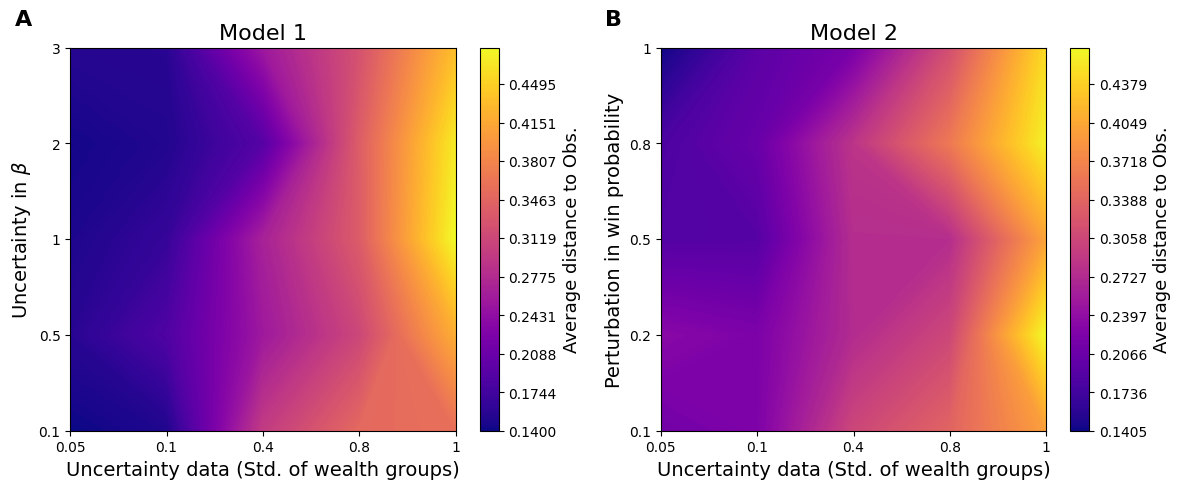

In [3]:
# Create a figure for the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot heatmap for Model 1 in the first subplot (ax1)
experiment.plot_heatmap(experiment.results_model1, "Model1", ax=ax1, save_fig=False)
ax1.set_title('Model 1', fontsize = 16)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot heatmap for Model 2 in the second subplot (ax2)
experiment.plot_heatmap(experiment.results_model2, "Model2", ax=ax2, save_fig=False)
ax2.set_title('Model 2', fontsize = 16)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the entire figure
plt.savefig('fig9.png', dpi=300)

# Show the plot
plt.show()